# FIN42330 Python for Financial Data Science  
## Group Project Assignment 

## Task 1
Given the monthly prices of two asset classes:  
- S&P 500 stock market index (SP500)  
- Bloomberg Barclays U.S. Aggregate Bond Index (LBUSTRUU)  

for the period from December 1979 to December 2023, calculate the simple rate of returns on these two datasets.  

Using the monthly risk-free rate of return data provided for the period January 1980 to December 2023, calculate the stock and bond simple excess returns. The dataset on the stock index, bond index, and risk-free rate is provided in the folder `Data_on_assets`.  

Write a Python function to compute the following statistics for the stock and bond simple excess returns:
- (a) annualized mean
- (b) annualized volatility
- (c) annualized Sharpe ratio
- (d) skewness
- (e) kurtosis


In [1]:
import pandas as pd
stock_data = pd.read_excel("/Users/nilaysinghsolanki/Downloads/Data_on_assets/S&P500_stock_price_index.xlsx", usecols=['Dates', 'stock index price '])
bond_data = pd.read_excel("/Users/nilaysinghsolanki/Downloads/Data_on_assets/US_Aggregate_bond_price_index.xlsx", usecols=['Dates', 'Bond index price '])
riskfree_data = pd.read_excel("/Users/nilaysinghsolanki/Downloads/Data_on_assets/Risk-free_rate_of_return.xlsx", usecols=['Date', 'Risk free rate of return '])


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Function to compute annualized statistics
def calculate_statistics(returns):
    annualized_mean = returns.mean() * 12
    annualized_volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = annualized_mean / annualized_volatility
    skewness = skew(returns)
    kurt = kurtosis(returns)
    return annualized_mean, annualized_volatility, sharpe_ratio, skewness, kurt

# Import datasets
stock_data = pd.read_excel(
    "/Users/nilaysinghsolanki/Downloads/Data_on_assets/S&P500_stock_price_index.xlsx",
    usecols=['Dates', 'stock index price ']
)

bond_data = pd.read_excel(
    "/Users/nilaysinghsolanki/Downloads/Data_on_assets/US_Aggregate_bond_price_index.xlsx",
    usecols=['Dates', 'Bond index price ']
)

riskfree_data = pd.read_excel(
    "/Users/nilaysinghsolanki/Downloads/Data_on_assets/Risk-free_rate_of_return.xlsx",
    usecols=['Date', 'Risk free rate of return ']
)

# Standardize column names
stock_data.columns = ['Date', 'Stock Index Price']
bond_data.columns = ['Date', 'Bond Index Price']
riskfree_data.columns = ['Date', 'Risk Free Rate']

# Convert dates to a standard datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m%d%Y')
bond_data['Date'] = pd.to_datetime(bond_data['Date'], format='%m%d%Y')
riskfree_data['Date'] = pd.to_datetime(riskfree_data['Date'], format='%m%d%Y')

# Merge datasets on the Date column
data = stock_data.merge(bond_data, on='Date').merge(riskfree_data, on='Date')

# Calculate monthly returns for stocks and bonds
data['Stock Monthly Returns'] = data['Stock Index Price'].pct_change()
data['Bond Monthly Returns'] = data['Bond Index Price'].pct_change()

# Calculate excess returns
data['Stock Excess Returns'] = data['Stock Monthly Returns'] - data['Risk Free Rate']
data['Bond Excess Returns'] = data['Bond Monthly Returns'] - data['Risk Free Rate']

# Remove rows with NaN values (from pct_change or missing risk-free rates)
cleaned_data = data.dropna(subset=['Stock Monthly Returns', 'Bond Monthly Returns',
                                   'Stock Excess Returns', 'Bond Excess Returns'])

# Compute statistics for stock and bond excess returns
stock_stats = calculate_statistics(cleaned_data['Stock Excess Returns'])
bond_stats = calculate_statistics(cleaned_data['Bond Excess Returns'])

# Get the time frame for the analysis
start_date = cleaned_data['Date'].min().strftime('%Y-%m-%d')
end_date = cleaned_data['Date'].max().strftime('%Y-%m-%d')

# Create a summary table for statistics
summary_table = pd.DataFrame({
    'Statistic': ['Annualized Mean', 'Annualized Volatility', 'Annualized Sharpe Ratio', 'Skewness', 'Kurtosis'],
    'Stock': stock_stats,
    'Bond': bond_stats
})

# Display the time frame and summary table
print(f"Time Frame for Analysis: {start_date} to {end_date}")
print("Summary Statistics for Excess Returns")
print(summary_table)

# Save computed data and statistics to an Excel file
with pd.ExcelWriter('Full_Results.xlsx') as writer:
    # Save computed returns and excess returns
    cleaned_data.to_excel(writer, sheet_name='Computed Returns', index=False)
    # Save summary statistics
    summary_table.to_excel(writer, sheet_name='Summary Statistics', index=False)

print("The results, including all calculated returns and statistics, have been saved to 'Full_Results.xlsx'.")


Time Frame for Analysis: 1980-02-29 to 2023-12-29
Summary Statistics for Excess Returns
                 Statistic     Stock      Bond
0          Annualized Mean  0.057901  0.028440
1    Annualized Volatility  0.152968  0.053048
2  Annualized Sharpe Ratio  0.378520  0.536123
3                 Skewness -0.589437  0.345699
4                 Kurtosis  1.785668  5.099843
The results, including all calculated returns and statistics, have been saved to 'Full_Results.xlsx'.


## Task 2
Divide the total sample of monthly excess returns on the bond and stock indexes calculated in **Task 1** above into two periods:
- In-sample period: January 1980 - December 2000  
- Out-of-sample period: January 2001 - December 2023  

Using a rolling window estimation approach, generate a time-series of monthly out-of-sample constant expected (mean) excess return forecasts (call it the benchmark forecast) for each of the two asset classes. Write a function to do this computation.


In [3]:
import pandas as pd
import numpy as np

def compute_statistics(stock_data, bond_data, riskfree_data):
    """
    Compute simple monthly returns and excess returns for stocks and bonds.
    """
    # Merge datasets on 'Date'
    data = pd.merge(stock_data, bond_data, on="Date")
    data = pd.merge(data, riskfree_data, on="Date")
    data.columns = ['Date', 'Stock_Index_Price', 'Bond_Index_Price', 'RiskFree_Rate']

    # Compute monthly returns
    data['Stock_Returns'] = data['Stock_Index_Price'].pct_change()
    data['Bond_Returns'] = data['Bond_Index_Price'].pct_change()

    # Compute excess returns
    data['Stock_Excess_Returns'] = data['Stock_Returns'] - data['RiskFree_Rate'] / 100
    data['Bond_Excess_Returns'] = data['Bond_Returns'] - data['RiskFree_Rate'] / 100

    # Drop rows with missing values
    data.dropna(inplace=True)

    return data

def rolling_window_forecast(excess_returns, window_size):
    """
    Generate rolling window out-of-sample mean excess return forecasts.
    """
    forecast = []
    for i in range(window_size, len(excess_returns)):
        # Compute the mean of the rolling window
        window_data = excess_returns.iloc[i - window_size:i]
        forecast.append(window_data.mean())
    # Return a Series aligned with the correct indices
    return pd.Series(forecast, index=excess_returns.index[window_size:])

# Import datasets
stock_data = pd.read_excel(
    "/Users/nilaysinghsolanki/Downloads/Data_on_assets/S&P500_stock_price_index.xlsx",
    usecols=['Dates', 'stock index price ']
)

bond_data = pd.read_excel(
    "/Users/nilaysinghsolanki/Downloads/Data_on_assets/US_Aggregate_bond_price_index.xlsx",
    usecols=['Dates', 'Bond index price ']
)

riskfree_data = pd.read_excel(
    "/Users/nilaysinghsolanki/Downloads/Data_on_assets/Risk-free_rate_of_return.xlsx",
    usecols=['Date', 'Risk free rate of return ']
)
# Rename columns for consistency
stock_data.rename(columns={'Dates': 'Date', 'stock index price ': 'Stock_Index_Price'}, inplace=True)
bond_data.rename(columns={'Dates': 'Date', 'Bond index price ': 'Bond_Index_Price'}, inplace=True)
riskfree_data.rename(columns={'Risk free rate of return ': 'RiskFree_Rate'}, inplace=True)

# Convert 'Date' columns to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
riskfree_data['Date'] = pd.to_datetime(riskfree_data['Date'])

# Compute statistics
data = compute_statistics(stock_data, bond_data, riskfree_data)

# Define in-sample and out-of-sample periods
in_sample_period = (data['Date'] >= pd.Timestamp("1980-01-01")) & (data['Date'] <= pd.Timestamp("2000-12-31"))
out_sample_period = (data['Date'] >= pd.Timestamp("2001-01-01")) & (data['Date'] <= pd.Timestamp("2023-12-31"))

in_sample_data = data[in_sample_period]
out_sample_data = data[out_sample_period]

# Generate rolling window forecasts for out-of-sample data
window_size = 12  # Rolling window of ~2 years
stock_out_sample_forecast = rolling_window_forecast(out_sample_data['Stock_Excess_Returns'], window_size)
bond_out_sample_forecast = rolling_window_forecast(out_sample_data['Bond_Excess_Returns'], window_size)

# Create the benchmark DataFrame
benchmark = pd.DataFrame({
    "Date": out_sample_data['Date'].iloc[window_size:].values,
    "Stock_Benchmark_Forecast": stock_out_sample_forecast.values,
    "Bond_Benchmark_Forecast": bond_out_sample_forecast.values
})

# Output benchmark and data for verification
print("Benchmark DataFrame:")
print(benchmark["Stock_Benchmark_Forecast"])

print("\nData Table:")
print(data)



Benchmark DataFrame:
0     -0.010091
1     -0.014271
2     -0.008309
3      0.000105
4     -0.011412
         ...   
259    0.010176
260    0.012234
261    0.015955
262    0.007466
263    0.010417
Name: Stock_Benchmark_Forecast, Length: 264, dtype: float64

Data Table:
          Date  Stock_Index_Price  Bond_Index_Price  RiskFree_Rate  \
1   1980-02-29             113.66            112.29         0.0089   
2   1980-03-31             102.09            112.38         0.0121   
3   1980-04-30             106.29            125.12         0.0126   
4   1980-05-30             111.24            131.02         0.0081   
5   1980-06-30             114.24            133.49         0.0061   
..         ...                ...               ...            ...   
523 2023-08-31            4507.66           2076.80         0.0045   
524 2023-09-29            4288.05           2024.02         0.0043   
525 2023-10-31            4193.80           1992.08         0.0047   
526 2023-11-30            4567

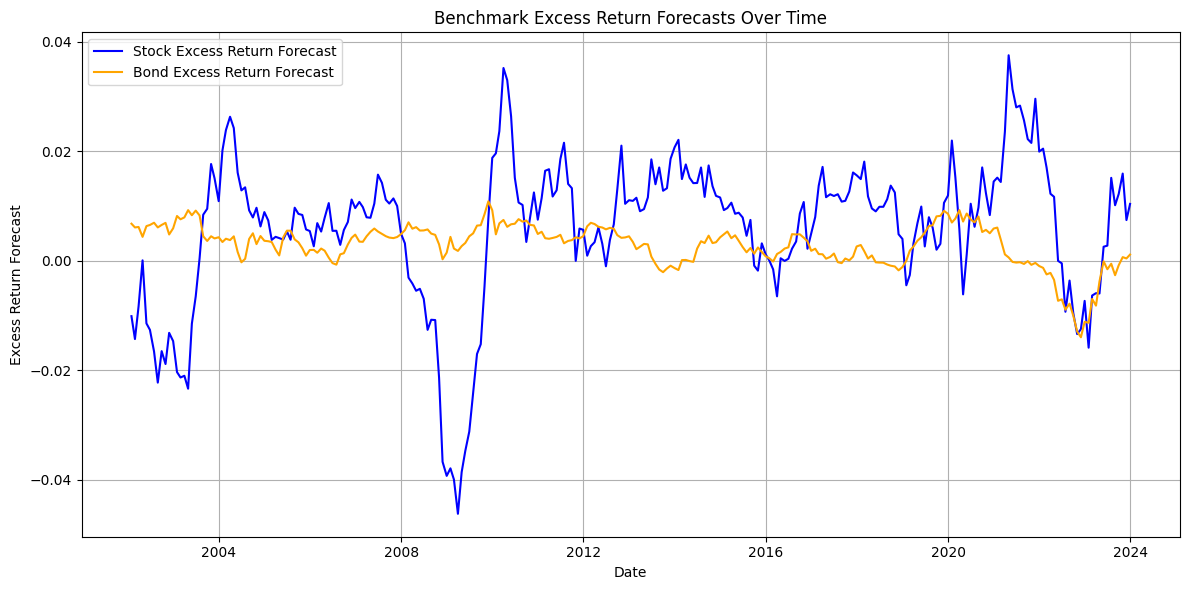

In [4]:
import matplotlib.pyplot as plt

# Plot the Stock and Bond Excess Return Benchmarks
plt.figure(figsize=(12, 6))

# Plot Stock Benchmark Forecast
plt.plot(benchmark["Date"], benchmark["Stock_Benchmark_Forecast"], label="Stock Excess Return Forecast", color='blue')

# Plot Bond Benchmark Forecast
plt.plot(benchmark["Date"], benchmark["Bond_Benchmark_Forecast"], label="Bond Excess Return Forecast", color='orange')

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Excess Return Forecast")
plt.title("Benchmark Excess Return Forecasts Over Time")
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
data_os = data[(data['Date'] >= "2001-01-01") & (data['Date'] <= "2023-12-31")]


## Task 3
Select the monthly data for five variables that you believe are plausible predictors of the excess returns on stocks and bonds (see, for example, Rapach, Ringgenberg, and Zhou, 2016 for stocks, Lin, Wu, and Zhou, 2017, and the references therein for inspiration) from the `Predictors2023` dataset provided. Based on each of your five predictors and using the same rolling window estimation approach, generate monthly out-of-sample excess return forecasts for each of the asset classes using the following three predictive models (call these model forecasts):
- (a) An ordinary least squares (OLS) predictive regression model for each of the five predictors  
- (b) A combination forecast of excess returns that is a simple average of the forecasts based on the five predictors from the OLS model in (a) above  

This leads to a total of 6 model forecasts for each of the stock and bond excess returns.  

Compute the mean squared forecast error (MSFE) for the benchmark forecast and the ratio of MSFE for each of the model forecasts relative to the MSFE of the benchmark forecast MSFE for each asset. For example, the MSFE of the benchmark forecast for stock excess returns is given by:

$$
MSFE = \frac{1}{T} \sum_{t=1}^{T} (R_t - \hat{R}_t)^2 = \frac{1}{T} \sum_{t=1}^{T} e_t^2
$$

where $\hat{R}_t$ is the benchmark forecast of stock excess return for period $t$, $R_t$ is the actual (realized) stock excess return in period $t$, $R_t - \hat{R}_t = e_t$ is the forecast error, and $T$ is the number of observations in the out-of-sample period.

Compare the performance of the model forecasts relative to the benchmark forecast using the **Diebold and Mariano (1995)** test for equal predictive ability (you should write your own function to perform this test). The test assesses whether the difference between the MSFEs of the benchmark forecast and the model forecast is statistically significant. You should clearly state the null hypothesis being tested and also provide a discussion of your table of results.  

In addition, create a figure showing the time-series of the benchmark and combination forecasts for each of the two asset classes.


For Task 3, the following five variables have been selected as plausible predictors of the excess returns on stocks and bonds:

- **Tms**: Term spread
- **Dfy**: Default yield spread
- **D/p**: Dividend price ratio
- **Shtint**: Short interest
- **Infl**: Inflation

These variables are sourced from the **‘Predictors2023’** dataset provided. Using these predictors, and the same rolling window estimation approach, we will generate monthly out-of-sample excess return forecasts for each of the asset classes (stocks and bonds) using the following three predictive models:



In [6]:
import pandas as pd

# Load data from the specified sheet in the external Excel file
file_path = r"/Users/nilaysinghsolanki/Downloads/PredictorData2023.xlsx"

# Read the data from the second sheet named "Monthly"
df = pd.read_excel(file_path, sheet_name='Monthly')

# Convert 'yyyymm' column to datetime format (YYYY-MM)
df['yyyymm'] = pd.to_datetime(df['yyyymm'], format='%Y%m')

# Filter the data to include dates between Jan 1980 and Dec 2000
filtered_data = df[(df['yyyymm'] >= '1980-01') & (df['yyyymm'] <= '2000-12')]

# Check the length of the original and filtered data
print("Original DataFrame length:", len(df))
print("Filtered DataFrame length:", len(filtered_data))

# Display the first few rows of filtered data
print(filtered_data)



Original DataFrame length: 1836
Filtered DataFrame length: 252
         yyyymm    price        d12        e12       ret      retx     AAA  \
1308 1980-01-01   114.16   5.700000  15.003300  0.061308  0.058935  0.1109   
1309 1980-02-01   113.66   5.750000  15.146700  0.002611 -0.005574  0.1238   
1310 1980-03-01   102.09   5.800000  15.290000 -0.097518 -0.100096  0.1296   
1311 1980-04-01   106.29   5.846670  15.173300  0.042394  0.039877  0.1204   
1312 1980-05-01   111.24   5.893330  15.056700  0.055560  0.046651  0.1099   
...         ...      ...        ...        ...       ...       ...     ...   
1555 2000-08-01  1517.68  16.466000  53.106667  0.062594  0.061275  0.0755   
1556 2000-09-01  1436.51  16.347000  53.700000 -0.052088 -0.052795  0.0762   
1557 2000-10-01  1429.40  16.321667  52.466667 -0.004120 -0.004829  0.0755   
1558 2000-11-01  1314.95  16.296333  51.233333 -0.078268 -0.079557  0.0745   
1559 2000-12-01  1320.28  16.271000  50.000000  0.005720  0.004861  0.0721   



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [7]:
data['Date'] = pd.to_datetime(data['Date']).dt.strftime('%m %Y')


**Tms**: Term spread

In [8]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your dataframe
# Sample data structure assumption (adjust it as needed)
# df = pd.read_csv('your_data.csv')  # Replace with actual data loading method

# Filter the data to include dates between Jan 2001 and Dec 2023
# filtered_data = df[(df['yyyymm'] >= '01 1980') & (df['yyyymm'] <= '12 2000')]
# print(len(df))
# Ensure 'tms' and 'retx' columns exist in the dataframe
# print(filtered_data)

# Function to generate rolling OLS forecasts
def generate_ols_forecasts(data, predictor, target, window_size):
    forecasts = []

    # Drop rows with missing values for predictor and target columns
    data_cleaned = data.dropna(subset=[predictor, target])

    # Iterate through the cleaned data using a rolling window
    for i in range(window_size, len(data_cleaned)):
        # Define the in-sample data
        in_sample_data = data_cleaned.iloc[i - window_size:i]

        # Define predictor (X) and target (y) for the OLS regression
        X_in_sample = in_sample_data[[predictor]]
        y_in_sample = in_sample_data[target]

        # Add a constant to the predictor for the OLS intercept
        X_in_sample = sm.add_constant(X_in_sample)

        # Fit the OLS model
        model = sm.OLS(y_in_sample, X_in_sample).fit()

        # Prepare the next period's predictor and add a constant for the prediction
        next_period_predictor = data_cleaned.iloc[i][[predictor]]
        next_period_predictor = sm.add_constant(next_period_predictor, has_constant='add')

        # Use the model to predict the next period's excess return
        forecast = model.predict(next_period_predictor)
        forecasts.append(forecast[0])

    # Return the forecasts as a Pandas Series
    return pd.Series(forecasts, index=data_cleaned.index[window_size:], name=f"{target}_forecast")

# Generate out-of-sample forecasts for stock and bond excess returns
# Using 'retx' for stock and bond excess returns
stock_forecast_tms = generate_ols_forecasts(filtered_data, predictor='tms', target='retx', window_size=12)
bond_forecast_tms = generate_ols_forecasts(filtered_data, predictor='tms', target='retx', window_size=12)

# Print the results for the first 30 rows
print("Stock Forecast (First 30 Rows):")
print(len(stock_forecast_tms))

print("\nBond Forecast (First 30 Rows):")
print(len(bond_forecast_tms))



/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/220199254.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/220199254.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/220199254.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Stock Forecast (First 30 Rows):
240

Bond Forecast (First 30 Rows):
240


/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/220199254.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/220199254.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/220199254.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

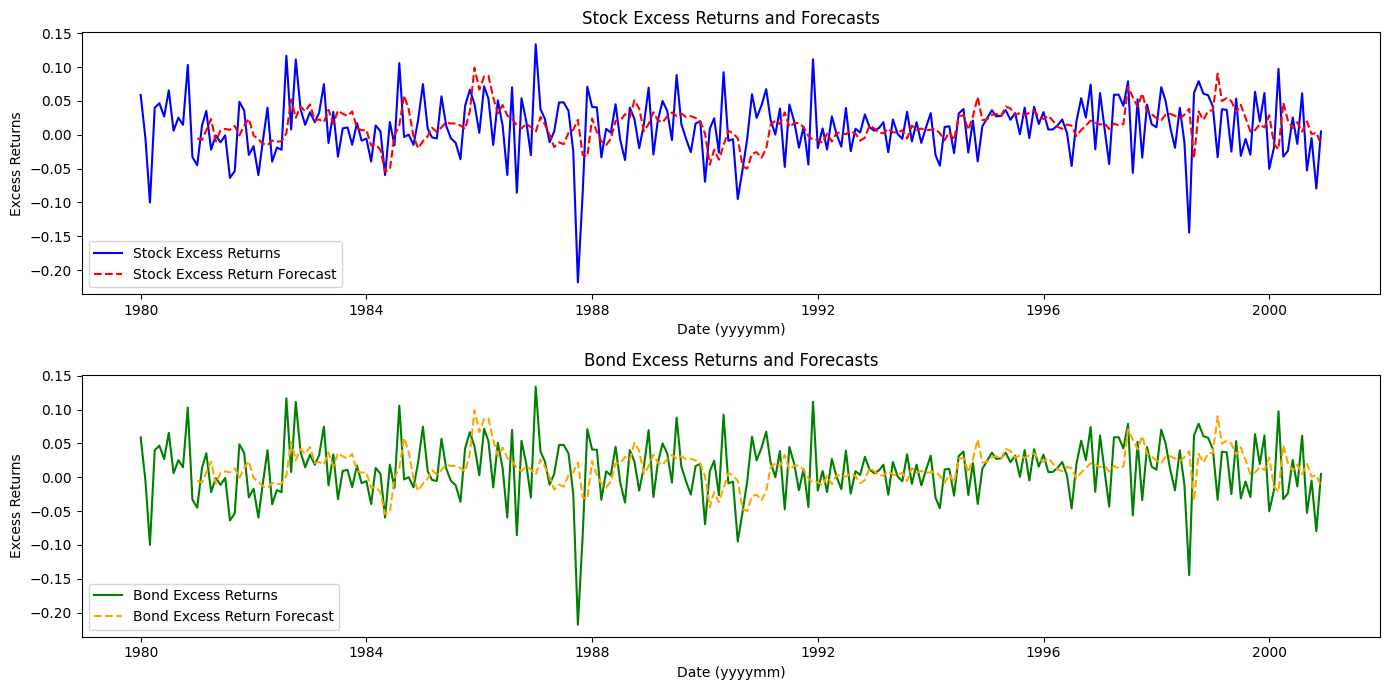

In [9]:
# Reindex the forecasts to align with the corresponding dates from filtered_data
stock_forecast_tms.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month
bond_forecast_tms.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month

# Plotting the excess returns and forecasts
plt.figure(figsize=(14, 7))

# Plot stock excess returns and forecast
plt.subplot(2, 1, 1)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Stock Excess Returns', color='blue')
# Align the forecast with the corresponding date range
plt.plot(stock_forecast_tms.index, stock_forecast_tms, label='Stock Excess Return Forecast', color='red', linestyle='--')
plt.title('Stock Excess Returns and Forecasts')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Plot bond excess returns and forecast
plt.subplot(2, 1, 2)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Bond Excess Returns', color='green')
# Align the forecast with the corresponding date range
plt.plot(bond_forecast_tms.index, bond_forecast_tms, label='Bond Excess Return Forecast', color='orange', linestyle='--')
plt.title('Bond Excess Returns and Forecasts')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


**D/p**: Dividend price ratio

In [10]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your dataframe
# Sample data structure assumption (adjust it as needed)
# df = pd.read_csv('your_data.csv')  # Replace with actual data loading method

# Filter the data to include dates between Jan 2001 and Dec 2023
# filtered_data = df[(df['yyyymm'] >= '01 1980') & (df['yyyymm'] <= '12 2000')]

# # Ensure 'tms' and 'retx' columns exist in the dataframe
# print(filtered_data.columns)

# Function to generate rolling OLS forecasts
def generate_ols_forecasts(data, predictor, target, window_size):
    forecasts = []

    # Drop rows with missing values for predictor and target columns
    data_cleaned = data.dropna(subset=[predictor, target])

    # Iterate through the cleaned data using a rolling window
    for i in range(window_size, len(data_cleaned)):
        # Define the in-sample data
        in_sample_data = data_cleaned.iloc[i - window_size:i]

        # Define predictor (X) and target (y) for the OLS regression
        X_in_sample = in_sample_data[[predictor]]
        y_in_sample = in_sample_data[target]

        # Add a constant to the predictor for the OLS intercept
        X_in_sample = sm.add_constant(X_in_sample)

        # Fit the OLS model
        model = sm.OLS(y_in_sample, X_in_sample).fit()

        # Prepare the next period's predictor and add a constant for the prediction
        next_period_predictor = data_cleaned.iloc[i][[predictor]]
        next_period_predictor = sm.add_constant(next_period_predictor, has_constant='add')

        # Use the model to predict the next period's excess return
        forecast = model.predict(next_period_predictor)
        forecasts.append(forecast[0])

    # Return the forecasts as a Pandas Series
    return pd.Series(forecasts, index=data_cleaned.index[window_size:], name=f"{target}_forecast")

# Generate out-of-sample forecasts for stock and bond excess returns
# Using 'retx' for stock and bond excess returns
stock_forecast_dp = generate_ols_forecasts(filtered_data, predictor='d/p', target='retx', window_size=12)
bond_forecast_dp = generate_ols_forecasts(filtered_data, predictor='d/p', target='retx', window_size=12)

# Print the results for the first 30 rows
print("Stock Forecast (First 30 Rows):")
print(stock_forecast_dp.head(30))

print("\nBond Forecast (First 30 Rows):")
print(bond_forecast_dp.head(30))
print("Stock Forecast (First 30 Rows):")
print(len(stock_forecast_dp))

print("\nBond Forecast (First 30 Rows):")
print(len(bond_forecast_dp))


/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/418802874.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/418802874.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/418802874.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Stock Forecast (First 30 Rows):
1320    0.034331
1321    0.024181
1322    0.030670
1323    0.024349
1324    0.019821
1325    0.012371
1326   -0.001664
1327   -0.058372
1328   -0.111386
1329   -0.057515
1330   -0.022084
1331   -0.012786
1332   -0.021904
1333   -0.035712
1334   -0.048122
1335   -0.027157
1336   -0.020780
1337   -0.029298
1338   -0.032074
1339   -0.015588
1340    0.002950
1341    0.039256
1342    0.070675
1343    0.066562
1344    0.068070
1345    0.065279
1346    0.057719
1347    0.059134
1348    0.061928
1349    0.046074
Name: retx_forecast, dtype: float64

Bond Forecast (First 30 Rows):
1320    0.034331
1321    0.024181
1322    0.030670
1323    0.024349
1324    0.019821
1325    0.012371
1326   -0.001664
1327   -0.058372
1328   -0.111386
1329   -0.057515
1330   -0.022084
1331   -0.012786
1332   -0.021904
1333   -0.035712
1334   -0.048122
1335   -0.027157
1336   -0.020780
1337   -0.029298
1338   -0.032074
1339   -0.015588
1340    0.002950
1341    0.039256
1342    0.070675

/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/418802874.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/418802874.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/418802874.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

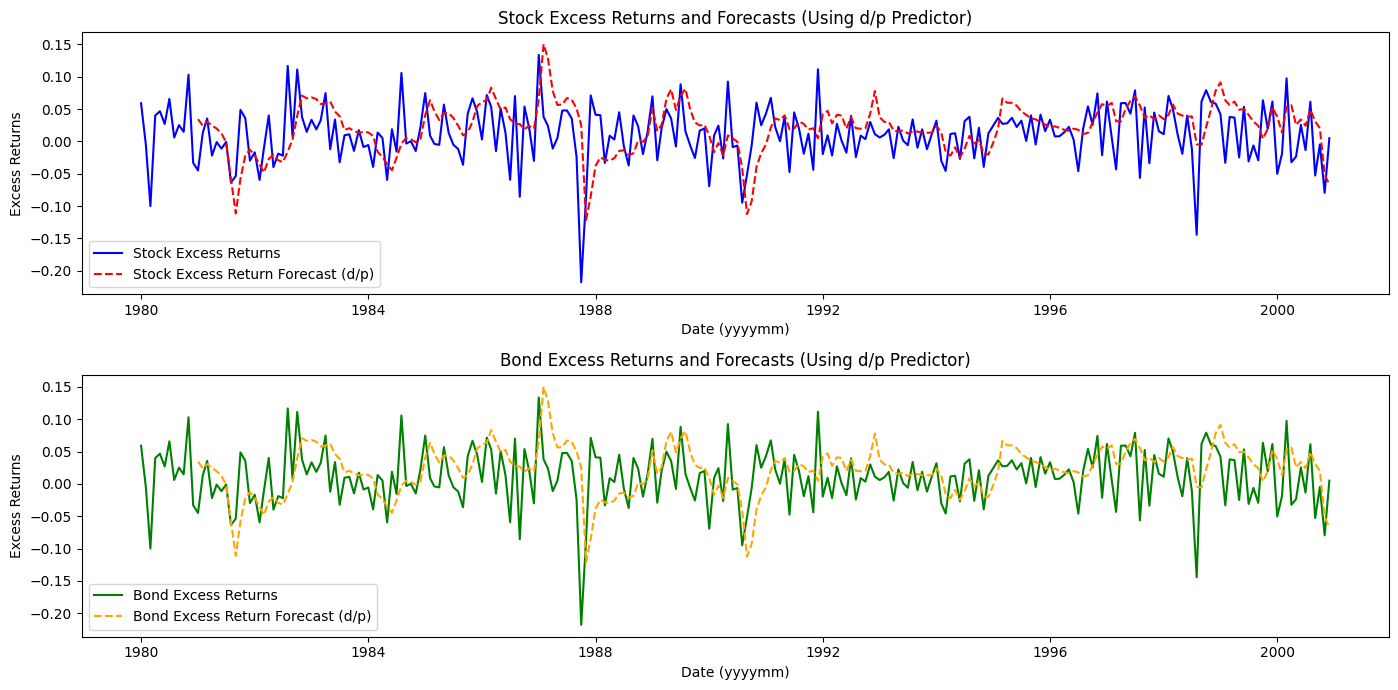

In [11]:
stock_forecast_dp.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month
bond_forecast_dp.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month

# Plotting the excess returns and forecasts for 'd/p'
plt.figure(figsize=(14, 7))

# Plot stock excess returns and forecast
plt.subplot(2, 1, 1)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Stock Excess Returns', color='blue')
# Align the forecast with the corresponding date range
plt.plot(stock_forecast_dp.index, stock_forecast_dp, label='Stock Excess Return Forecast (d/p)', color='red', linestyle='--')
plt.title('Stock Excess Returns and Forecasts (Using d/p Predictor)')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Plot bond excess returns and forecast
plt.subplot(2, 1, 2)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Bond Excess Returns', color='green')
# Align the forecast with the corresponding date range
plt.plot(bond_forecast_dp.index, bond_forecast_dp, label='Bond Excess Return Forecast (d/p)', color='orange', linestyle='--')
plt.title('Bond Excess Returns and Forecasts (Using d/p Predictor)')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

**Dfy**: Default yield spread

In [12]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your dataframe
# Sample data structure assumption (adjust it as needed)
# df = pd.read_csv('your_data.csv')  # Replace with actual data loading method

# Filter the data to include dates between Jan 2001 and Dec 2023
# filtered_data = df[(df['yyyymm'] >= '01 1980') & (df['yyyymm'] <= '12 2000')]
# print(len(filtered_data))
# # Ensure 'tms' and 'retx' columns exist in the dataframe
# print(filtered_data.columns)

# Function to generate rolling OLS forecasts
def generate_ols_forecasts(data, predictor, target, window_size):
    forecasts = []

    # Drop rows with missing values for predictor and target columns
    data_cleaned = data.dropna(subset=[predictor, target])

    # Iterate through the cleaned data using a rolling window
    for i in range(window_size, len(data_cleaned)):
        # Define the in-sample data
        in_sample_data = data_cleaned.iloc[i - window_size:i]

        # Define predictor (X) and target (y) for the OLS regression
        X_in_sample = in_sample_data[[predictor]]
        y_in_sample = in_sample_data[target]

        # Add a constant to the predictor for the OLS intercept
        X_in_sample = sm.add_constant(X_in_sample)

        # Fit the OLS model
        model = sm.OLS(y_in_sample, X_in_sample).fit()

        # Prepare the next period's predictor and add a constant for the prediction
        next_period_predictor = data_cleaned.iloc[i][[predictor]]
        next_period_predictor = sm.add_constant(next_period_predictor, has_constant='add')

        # Use the model to predict the next period's excess return
        forecast = model.predict(next_period_predictor)
        forecasts.append(forecast[0])

    # Return the forecasts as a Pandas Series
    return pd.Series(forecasts, index=data_cleaned.index[window_size:], name=f"{target}_forecast")

# Generate out-of-sample forecasts for stock and bond excess returns
# Using 'retx' for stock and bond excess returns
stock_forecast_dfy = generate_ols_forecasts(filtered_data, predictor='dfy', target='retx', window_size=12)
bond_forecast_dfy = generate_ols_forecasts(filtered_data, predictor='dfy', target='retx', window_size=12)

# Print the results for the first 30 rows
print("Stock Forecast (First 30 Rows):")
print(stock_forecast_dfy.head(30))

print("\nBond Forecast (First 30 Rows):")
print(bond_forecast_dfy.head(30))


/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/671446087.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/671446087.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/671446087.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Stock Forecast (First 30 Rows):
1320    0.032741
1321    0.015638
1322    0.015024
1323    0.038178
1324    0.032043
1325    0.002068
1326    0.015547
1327    0.032762
1328    0.005503
1329   -0.008258
1330    0.003836
1331    0.017970
1332   -0.006196
1333   -0.002076
1334    0.007629
1335    0.000565
1336    0.012743
1337   -0.008296
1338   -0.006343
1339    0.006900
1340    0.040480
1341    0.023864
1342    0.057397
1343    0.007209
1344   -0.012258
1345   -0.043534
1346   -0.023948
1347   -0.010327
1348    0.010130
1349    0.004220
Name: retx_forecast, dtype: float64

Bond Forecast (First 30 Rows):
1320    0.032741
1321    0.015638
1322    0.015024
1323    0.038178
1324    0.032043
1325    0.002068
1326    0.015547
1327    0.032762
1328    0.005503
1329   -0.008258
1330    0.003836
1331    0.017970
1332   -0.006196
1333   -0.002076
1334    0.007629
1335    0.000565
1336    0.012743
1337   -0.008296
1338   -0.006343
1339    0.006900
1340    0.040480
1341    0.023864
1342    0.057397

/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/671446087.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/671446087.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/671446087.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

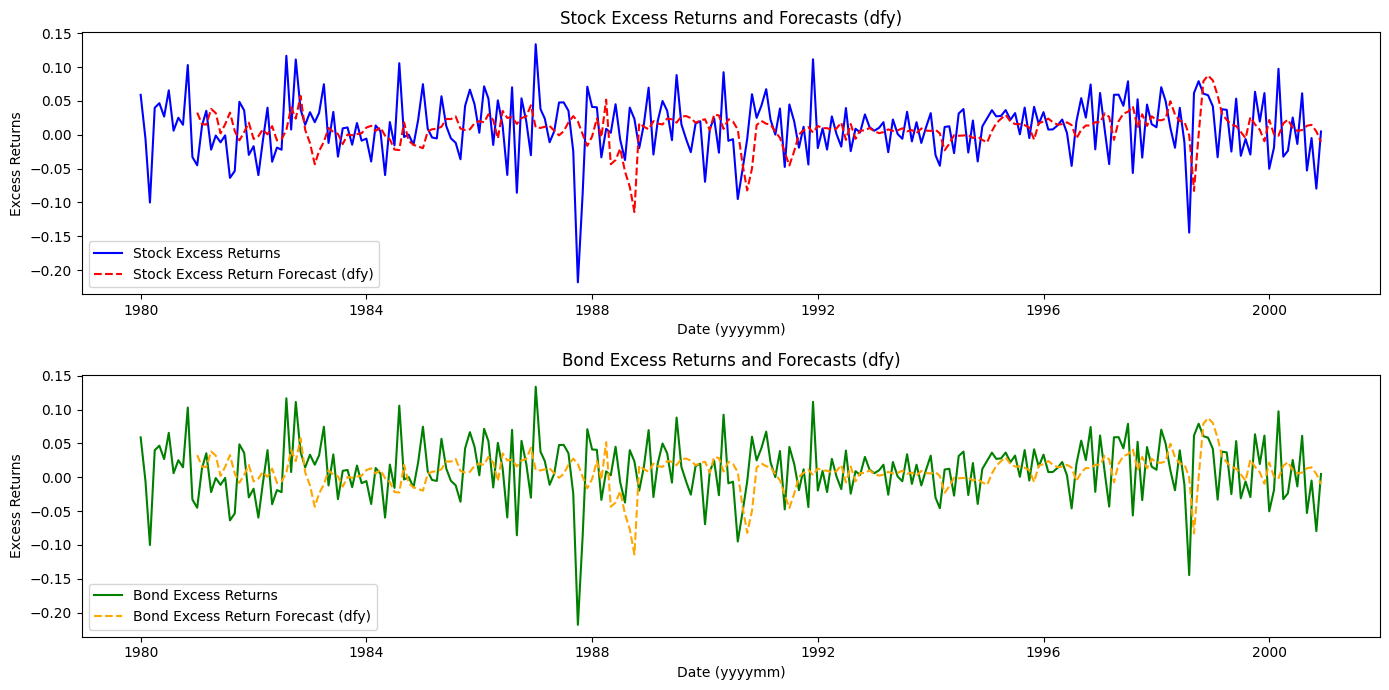

In [13]:
# Generate out-of-sample forecasts for stock and bond excess returns using 'dfy' as the predictor
# stock_forecast_dfy = generate_ols_forecasts(filtered_data, predictor='dfy', target='retx', window_size=12)
# bond_forecast_dfy = generate_ols_forecasts(filtered_data, predictor='dfy', target='retx', window_size=12)

# Reindex the forecasts to align with the corresponding dates from filtered_data
stock_forecast_dfy.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month
bond_forecast_dfy.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month

# Plotting the excess returns and forecasts
plt.figure(figsize=(14, 7))

# Plot stock excess returns and forecast
plt.subplot(2, 1, 1)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Stock Excess Returns', color='blue')
# Align the forecast with the corresponding date range
plt.plot(stock_forecast_dfy.index, stock_forecast_dfy, label='Stock Excess Return Forecast (dfy)', color='red', linestyle='--')
plt.title('Stock Excess Returns and Forecasts (dfy)')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Plot bond excess returns and forecast
plt.subplot(2, 1, 2)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Bond Excess Returns', color='green')
# Align the forecast with the corresponding date range
plt.plot(bond_forecast_dfy.index, bond_forecast_dfy, label='Bond Excess Return Forecast (dfy)', color='orange', linestyle='--')
plt.title('Bond Excess Returns and Forecasts (dfy)')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


**Infl**: Inflation

In [14]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your dataframe
# Sample data structure assumption (adjust it as needed)
# df = pd.read_csv('your_data.csv')  # Replace with actual data loading method

# Filter the data to include dates between Jan 2001 and Dec 2023
# filtered_data = df[(df['yyyymm'] >= '01 1980') & (df['yyyymm'] <= '12 2000')]

# # Ensure 'tms' and 'retx' columns exist in the dataframe
# print(filtered_data.columns)

# Function to generate rolling OLS forecasts
def generate_ols_forecasts(data, predictor, target, window_size):
    forecasts = []

    # Drop rows with missing values for predictor and target columns
    data_cleaned = data.dropna(subset=[predictor, target])

    # Iterate through the cleaned data using a rolling window
    for i in range(window_size, len(data_cleaned)):
        # Define the in-sample data
        in_sample_data = data_cleaned.iloc[i - window_size:i]

        # Define predictor (X) and target (y) for the OLS regression
        X_in_sample = in_sample_data[[predictor]]
        y_in_sample = in_sample_data[target]

        # Add a constant to the predictor for the OLS intercept
        X_in_sample = sm.add_constant(X_in_sample)

        # Fit the OLS model
        model = sm.OLS(y_in_sample, X_in_sample).fit()

        # Prepare the next period's predictor and add a constant for the prediction
        next_period_predictor = data_cleaned.iloc[i][[predictor]]
        next_period_predictor = sm.add_constant(next_period_predictor, has_constant='add')

        # Use the model to predict the next period's excess return
        forecast = model.predict(next_period_predictor)
        forecasts.append(forecast[0])

    # Return the forecasts as a Pandas Series
    return pd.Series(forecasts, index=data_cleaned.index[window_size:], name=f"{target}_forecast")

# Generate out-of-sample forecasts for stock and bond excess returns
# Using 'retx' for stock and bond excess returns
stock_forecast_infl = generate_ols_forecasts(filtered_data, predictor='infl', target='retx', window_size=12)
bond_forecast_infl = generate_ols_forecasts(filtered_data, predictor='infl', target='retx', window_size=12)

# Print the results for the first 30 rows
print("Stock Forecast (First 30 Rows):")
print(stock_forecast_infl.head(30))

print("\nBond Forecast (First 30 Rows):")
print(bond_forecast_infl.head(30))


/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/4125238122.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/4125238122.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/4125238122.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

Stock Forecast (First 30 Rows):
1320    0.031241
1321    0.004784
1322    0.031293
1323    0.030345
1324    0.020199
1325    0.010825
1326   -0.007773
1327    0.008829
1328    0.002916
1329    0.002355
1330    0.028995
1331    0.026030
1332    0.011978
1333    0.007394
1334    0.009882
1335   -0.012211
1336   -0.022212
1337   -0.038784
1338   -0.012337
1339   -0.002642
1340    0.013956
1341    0.008869
1342    0.038500
1343    0.045349
1344    0.017289
1345    0.024922
1346    0.034073
1347    0.009528
1348    0.020860
1349    0.032566
Name: retx_forecast, dtype: float64

Bond Forecast (First 30 Rows):
1320    0.031241
1321    0.004784
1322    0.031293
1323    0.030345
1324    0.020199
1325    0.010825
1326   -0.007773
1327    0.008829
1328    0.002916
1329    0.002355
1330    0.028995
1331    0.026030
1332    0.011978
1333    0.007394
1334    0.009882
1335   -0.012211
1336   -0.022212
1337   -0.038784
1338   -0.012337
1339   -0.002642
1340    0.013956
1341    0.008869
1342    0.038500

/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/4125238122.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/4125238122.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/4125238122.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

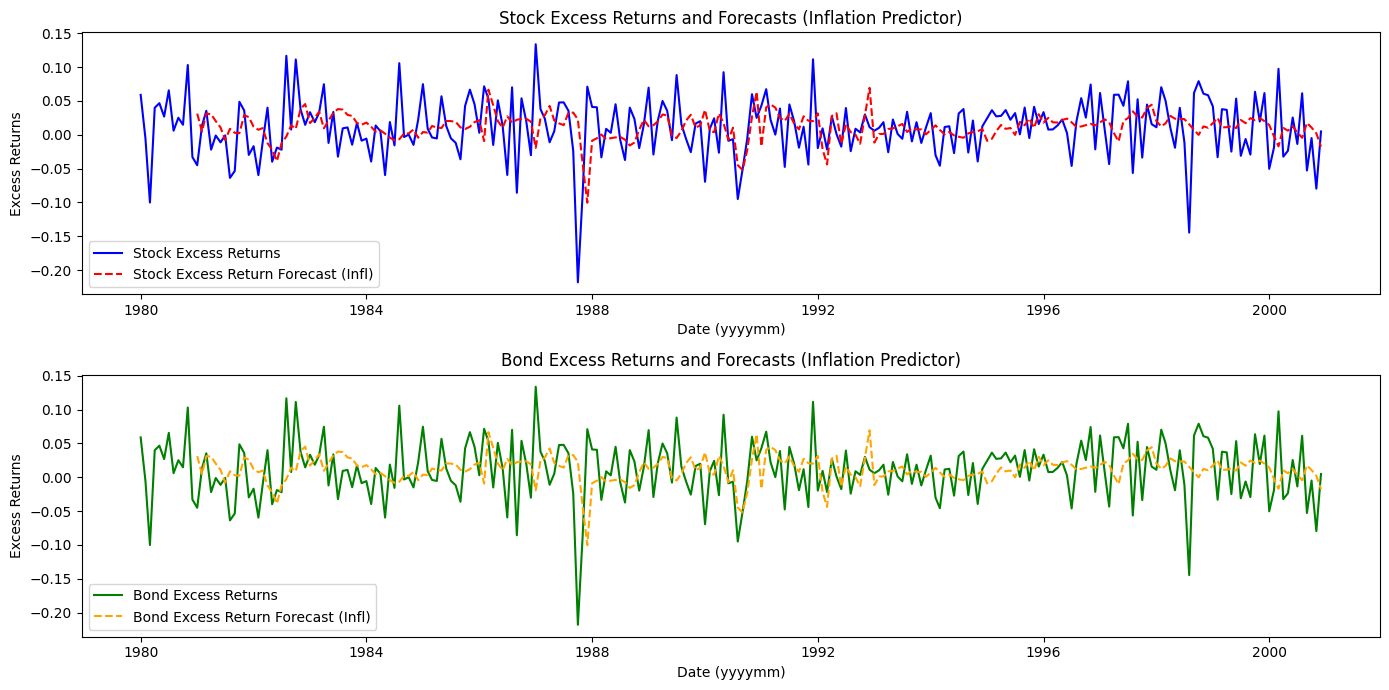

In [15]:
# Generate forecasts using 'infl' as the predictor
# stock_forecast_infl = generate_ols_forecasts(filtered_data, predictor='infl', target='retx', window_size=12)
# bond_forecast_infl = generate_ols_forecasts(filtered_data, predictor='infl', target='retx', window_size=12)

# Reindex the forecasts to align with the corresponding dates from filtered_data
stock_forecast_infl.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month
bond_forecast_infl.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month

# Plotting the excess returns and forecasts for inflation predictor
plt.figure(figsize=(14, 7))

# Plot stock excess returns and forecast
plt.subplot(2, 1, 1)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Stock Excess Returns', color='blue')
# Align the forecast with the corresponding date range
plt.plot(stock_forecast_infl.index, stock_forecast_infl, label='Stock Excess Return Forecast (Infl)', color='red', linestyle='--')
plt.title('Stock Excess Returns and Forecasts (Inflation Predictor)')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Plot bond excess returns and forecast
plt.subplot(2, 1, 2)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Bond Excess Returns', color='green')
# Align the forecast with the corresponding date range
plt.plot(bond_forecast_infl.index, bond_forecast_infl, label='Bond Excess Return Forecast (Infl)', color='orange', linestyle='--')
plt.title('Bond Excess Returns and Forecasts (Inflation Predictor)')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


**Shtint**: Short interest

In [16]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your dataframe
# Sample data structure assumption (adjust it as needed)
# df = pd.read_csv('your_data.csv')  # Replace with actual data loading method

# Filter the data to include dates between Jan 2001 and Dec 2023
# filtered_data = df[(df['yyyymm'] >= '01 1980') & (df['yyyymm'] <= '12 2000')]

# # Ensure 'tms' and 'retx' columns exist in the dataframe
# print(filtered_data.columns)

# Function to generate rolling OLS forecasts
def generate_ols_forecasts(data, predictor, target, window_size):
    forecasts = []

    # Drop rows with missing values for predictor and target columns
    data_cleaned = data.dropna(subset=[predictor, target])

    # Iterate through the cleaned data using a rolling window
    for i in range(window_size, len(data_cleaned)):
        # Define the in-sample data
        in_sample_data = data_cleaned.iloc[i - window_size:i]

        # Define predictor (X) and target (y) for the OLS regression
        X_in_sample = in_sample_data[[predictor]]
        y_in_sample = in_sample_data[target]

        # Add a constant to the predictor for the OLS intercept
        X_in_sample = sm.add_constant(X_in_sample)

        # Fit the OLS model
        model = sm.OLS(y_in_sample, X_in_sample).fit()

        # Prepare the next period's predictor and add a constant for the prediction
        next_period_predictor = data_cleaned.iloc[i][[predictor]]
        next_period_predictor = sm.add_constant(next_period_predictor, has_constant='add')

        # Use the model to predict the next period's excess return
        forecast = model.predict(next_period_predictor)
        forecasts.append(forecast[0])

    # Return the forecasts as a Pandas Series
    return pd.Series(forecasts, index=data_cleaned.index[window_size:], name=f"{target}_forecast")

# Generate out-of-sample forecasts for stock and bond excess returns
# Using 'retx' for stock and bond excess returns
stock_forecast_shtint = generate_ols_forecasts(filtered_data, predictor='shtint', target='retx', window_size=12)
bond_forecast_shtint = generate_ols_forecasts(filtered_data, predictor='shtint', target='retx', window_size=12)

# Print the results for the first 30 rows
print("Stock Forecast (First 30 Rows):")
print(stock_forecast_shtint.head(10))

print("\nBond Forecast (First 30 Rows):")
print(bond_forecast_shtint.head(10))
print("Stock Forecast (First 30 Rows):")
print(len(stock_forecast_shtint))

print("\nBond Forecast (First 30 Rows):")
print(len(bond_forecast_shtint))



/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/1522080742.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/1522080742.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/1522080742.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

Stock Forecast (First 30 Rows):
1320    0.024844
1321    0.018704
1322    0.013146
1323    0.023390
1324    0.016125
1325    0.020696
1326    0.017611
1327    0.001600
1328   -0.028224
1329   -0.026399
Name: retx_forecast, dtype: float64

Bond Forecast (First 30 Rows):
1320    0.024844
1321    0.018704
1322    0.013146
1323    0.023390
1324    0.016125
1325    0.020696
1326    0.017611
1327    0.001600
1328   -0.028224
1329   -0.026399
Name: retx_forecast, dtype: float64
Stock Forecast (First 30 Rows):
240

Bond Forecast (First 30 Rows):
240


/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/1522080742.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/1522080742.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/1522080742.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

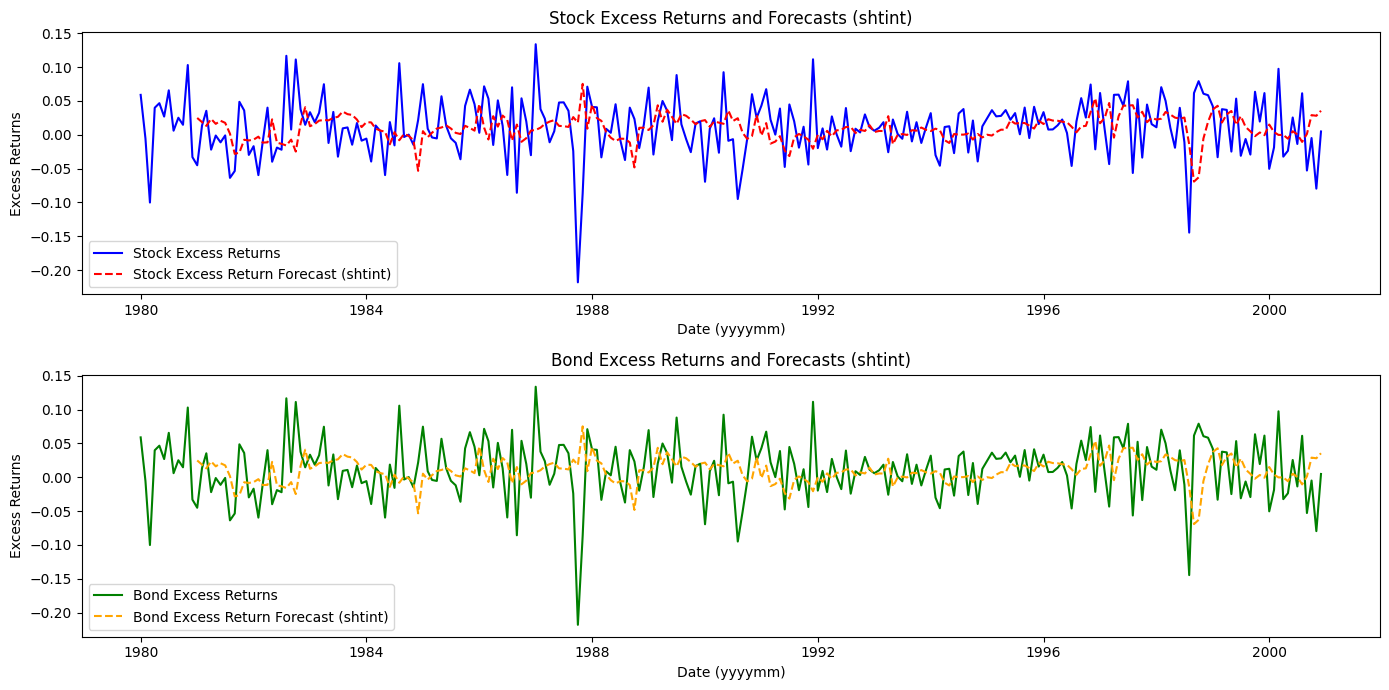

In [17]:
# Generate out-of-sample forecasts for stock and bond excess returns using 'shtint'
# stock_forecast_shtint = generate_ols_forecasts(filtered_data, predictor='shtint', target='retx', window_size=12)
# bond_forecast_shtint = generate_ols_forecasts(filtered_data, predictor='shtint', target='retx', window_size=12)

# Reindex the forecasts to align with the corresponding dates from filtered_data
stock_forecast_shtint.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month
bond_forecast_shtint.index = filtered_data['yyyymm'].iloc[12:].values  # Align forecast with dates starting from the 12th month

# Plotting the excess returns and forecasts for shtint
plt.figure(figsize=(14, 7))

# Plot stock excess returns and forecast for shtint
plt.subplot(2, 1, 1)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Stock Excess Returns', color='blue')
# Align the forecast with the corresponding date range
plt.plot(stock_forecast_shtint.index, stock_forecast_shtint, label='Stock Excess Return Forecast (shtint)', color='red', linestyle='--')
plt.title('Stock Excess Returns and Forecasts (shtint)')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Plot bond excess returns and forecast for shtint
plt.subplot(2, 1, 2)
plt.plot(filtered_data['yyyymm'], filtered_data['retx'], label='Bond Excess Returns', color='green')
# Align the forecast with the corresponding date range
plt.plot(bond_forecast_shtint.index, bond_forecast_shtint, label='Bond Excess Return Forecast (shtint)', color='orange', linestyle='--')
plt.title('Bond Excess Returns and Forecasts (shtint)')
plt.xlabel('Date (yyyymm)')
plt.ylabel('Excess Returns')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


(b) A combination forecast of excess returns that is a simple average of the forecasts based on the five predictors from the OLS model in (a) above  

This leads to a total of 6 model forecasts for each of the stock and bond excess returns.  

Compute the mean squared forecast error (MSFE) for the benchmark forecast and the ratio of MSFE for each of the model forecasts relative to the MSFE of the benchmark forecast MSFE for each asset. For example, the MSFE of the benchmark forecast for stock excess returns is given by:

$$
MSFE = \frac{1}{T} \sum_{t=1}^{T} (R_t - \hat{R}_t)^2 = \frac{1}{T} \sum_{t=1}^{T} e_t^2
$$

where $\hat{R}_t$ is the benchmark forecast of stock excess return for period $t$, $R_t$ is the actual (realized) stock excess return in period $t$, $R_t - \hat{R}_t = e_t$ is the forecast error, and $T$ is the number of observations in the out-of-sample period.

Compare the performance of the model forecasts relative to the benchmark forecast using the **Diebold and Mariano (1995)** test for equal predictive ability (you should write your own function to perform this test). The test assesses whether the difference between the MSFEs of the benchmark forecast and the model forecast is statistically significant. You should clearly state the null hypothesis being tested and also provide a discussion of your table of results.  

In addition, create a figure showing the time-series of the benchmark and combination forecasts for each of the two asset classes.


In [18]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your dataframe
# Sample data structure assumption (adjust it as needed)
# df = pd.read_csv('your_data.csv')  # Replace with actual data loading method

# Filter the data to include dates between Jan 2001 and Dec 2023
# filtered_data = df[(df['yyyymm'] >= '01 2001') & (df['yyyymm'] <= '12 2023')]

# # Check for missing values in the relevant columns
# #print(filtered_data[['tms', 'dfy', 'd/p', 'shtint', 'infl', 'retx']].isnull().sum())

# Drop rows with missing values for predictor and target columns
filtered_data_cleaned = filtered_data.dropna(subset=['tms', 'dfy', 'd/p', 'shtint', 'infl', 'retx'])

# Reset the index after dropping rows with NaN values
filtered_data_cleaned = filtered_data_cleaned.reset_index(drop=True)

# Function to generate rolling OLS forecasts
def generate_ols_forecasts(data, predictor, target, window_size):
    forecasts = []

    # Iterate through the cleaned data using a rolling window
    for i in range(window_size, len(data)):
        # Define the in-sample data
        in_sample_data = data.iloc[i - window_size:i]

        # Define predictor (X) and target (y) for the OLS regression
        X_in_sample = in_sample_data[[predictor]]
        y_in_sample = in_sample_data[target]

        # Add a constant to the predictor for the OLS intercept
        X_in_sample = sm.add_constant(X_in_sample)

        # Fit the OLS model
        model = sm.OLS(y_in_sample, X_in_sample).fit()

        # Prepare the next period's predictor and add a constant for the prediction
        next_period_predictor = sm.add_constant(data.iloc[i][[predictor]], has_constant='add')

        # Use the model to predict the next period's excess return
        forecast = model.predict(next_period_predictor)
        forecasts.append(forecast[0])

    # Return the forecasts as a Pandas Series
    return pd.Series(forecasts, index=data.index[window_size:], name=f"{target}_{predictor}_forecast")

# Generate out-of-sample forecasts for each predictor (5 in total)
stock_forecast_tms = generate_ols_forecasts(filtered_data_cleaned, predictor='tms', target='retx', window_size=12)
stock_forecast_dfy = generate_ols_forecasts(filtered_data_cleaned, predictor='dfy', target='retx', window_size=12)
stock_forecast_dpr = generate_ols_forecasts(filtered_data_cleaned, predictor='d/p', target='retx', window_size=12)
stock_forecast_shtint = generate_ols_forecasts(filtered_data_cleaned, predictor='shtint', target='retx', window_size=12)
stock_forecast_infl = generate_ols_forecasts(filtered_data_cleaned, predictor='infl', target='retx', window_size=12)

# Combine the forecasts by averaging them
combined_forecast_stock = (stock_forecast_tms + stock_forecast_dfy + stock_forecast_dpr + stock_forecast_shtint + stock_forecast_infl) / 5
combined_forecast_stock = combined_forecast_stock.reset_index(drop=True)
combined_forecast_bond =  (bond_forecast_tms + bond_forecast_dfy + bond_forecast_dp + bond_forecast_shtint + bond_forecast_infl) / 5
# for t in range(min(len(stock_forecasts), len(rolling_cov_matrices), len(realized_excess_returns))):
combined_forecast_bond
# Reindex combined_forecast_bond starting from 0
combined_forecast_bond = combined_forecast_bond.reset_index(drop=True)


# Print the combined forecast for the first 30 rows
print("Combined Stock Forecast :")
print(combined_forecast_stock)
print("Combined Bond Forecast :")
print(combined_forecast_bond)
#print(len(stock_forecast_dfy))


/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/413088629.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/413088629.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/413088629.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Combined Stock Forecast :
0      0.023585
1      0.011106
2      0.019441
3      0.027891
4      0.015685
         ...   
235    0.009161
236    0.016510
237    0.015123
238   -0.002702
239   -0.014610
Length: 240, dtype: float64
Combined Bond Forecast :
0      0.023585
1      0.011106
2      0.019441
3      0.027891
4      0.015685
         ...   
235    0.009161
236    0.016510
237    0.015123
238   -0.002702
239   -0.014610
Name: retx_forecast, Length: 240, dtype: float64


/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/413088629.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/413088629.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(forecast[0])
/var/folders/j7/hxbjlz2x3z70rz7y3w31ll500000gn/T/ipykernel_50472/413088629.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

In [19]:
data_os = data_os.reset_index(drop=True)
benchmark = benchmark.reset_index(drop=True)
stock_forecast_tms = stock_forecast_tms.reset_index(drop=True)
bond_forecast_tms = bond_forecast_tms.reset_index(drop=True)
stock_forecast_dp = stock_forecast_dp.reset_index(drop=True)
bond_forecast_dp = bond_forecast_dp.reset_index(drop=True)
stock_forecast_dfy = stock_forecast_dfy.reset_index(drop=True)
bond_forecast_dfy = bond_forecast_dfy.reset_index(drop=True)
stock_forecast_shtint = stock_forecast_shtint.reset_index(drop=True)
bond_forecast_shtint = bond_forecast_shtint.reset_index(drop=True)
stock_forecast_infl = stock_forecast_infl.reset_index(drop=True)
bond_forecast_infl = bond_forecast_infl.reset_index(drop=True)



In [20]:
import pandas as pd

def calculate_msfe(out_of_sample, forecast) -> float:
    """
    Calculate the Mean Squared Forecast Error (MSFE) between two series or dataframes.

    Args:
        out_of_sample : The out-of-sample data (actual values).
        forecast : The benchmark forecast data (predicted values).

    Returns:
        float: The Mean Squared Forecast Error (MSFE).
    """
    # Ensure both are pandas Series if not already
    if isinstance(out_of_sample, pd.Series) and isinstance(forecast, pd.Series):
        squared_errors = (out_of_sample - forecast) ** 2
        msfe = squared_errors.mean()  # Mean for the series
    else:
        # If input data is not Series, convert them to Series or raise an error
        raise ValueError("Both inputs must be pandas Series.")
    
    return msfe

# Example usage
msfe_b_stock = calculate_msfe(data_os['Stock_Excess_Returns'], benchmark["Stock_Benchmark_Forecast"])
msfe_b_bond = calculate_msfe(data_os['Bond_Excess_Returns'], benchmark["Bond_Benchmark_Forecast"])
msfe_tms_stock = calculate_msfe(data_os['Stock_Excess_Returns'], stock_forecast_tms)
msfe_tms_bond = calculate_msfe(data_os['Bond_Excess_Returns'], bond_forecast_tms)
msfe_dp_stock = calculate_msfe(data_os['Stock_Excess_Returns'], stock_forecast_dp)
msfe_dp_bond = calculate_msfe(data_os['Bond_Excess_Returns'], bond_forecast_dp)
msfe_dfy_stock = calculate_msfe(data_os['Stock_Excess_Returns'], stock_forecast_dfy)
msfe_dfy_bond = calculate_msfe(data_os['Bond_Excess_Returns'], bond_forecast_dfy)
msfe_shtint_stock = calculate_msfe(data_os['Stock_Excess_Returns'], stock_forecast_shtint)
msfe_shtint_bond = calculate_msfe(data_os['Bond_Excess_Returns'], bond_forecast_shtint)
msfe_infl_stock = calculate_msfe(data_os['Stock_Excess_Returns'], stock_forecast_infl)
msfe_infl_bond = calculate_msfe(data_os['Bond_Excess_Returns'], bond_forecast_infl)





In [21]:

# Calculate MSFE ratio relative to the benchmark forecast
ratio_tms_stock = msfe_tms_stock / msfe_b_stock
ratio_tms_bond = msfe_tms_bond / msfe_b_bond

ratio_dp_stock = msfe_dp_stock / msfe_b_stock
ratio_dp_bond = msfe_dp_bond / msfe_b_bond

ratio_dfy_stock = msfe_dfy_stock / msfe_b_stock
ratio_dfy_bond = msfe_dfy_bond / msfe_b_bond

ratio_shtint_stock = msfe_shtint_stock / msfe_b_stock
ratio_shtint_bond = msfe_shtint_bond / msfe_b_bond

ratio_infl_stock = msfe_infl_stock / msfe_b_stock
ratio_infl_bond = msfe_infl_bond / msfe_b_bond

# Display the results (ratios)
print(f"TMS Stock vs Benchmark: {ratio_tms_stock}")
print(f"TMS Bond vs Benchmark: {ratio_tms_bond}")
print(f"DP Stock vs Benchmark: {ratio_dp_stock}")
print(f"DP Bond vs Benchmark: {ratio_dp_bond}")
print(f"DFY Stock vs Benchmark: {ratio_dfy_stock}")
print(f"DFY Bond vs Benchmark: {ratio_dfy_bond}")
print(f"SHTINT Stock vs Benchmark: {ratio_shtint_stock}")
print(f"SHTINT Bond vs Benchmark: {ratio_shtint_bond}")
print(f"INFL Stock vs Benchmark: {ratio_infl_stock}")
print(f"INFL Bond vs Benchmark: {ratio_infl_bond}")


TMS Stock vs Benchmark: 1.3970025246705782
TMS Bond vs Benchmark: 6.689823652294387
DP Stock vs Benchmark: 1.7352824203640287
DP Bond vs Benchmark: 16.11814684935169
DFY Stock vs Benchmark: 1.1174281644041402
DFY Bond vs Benchmark: 5.297606674179317
SHTINT Stock vs Benchmark: 1.1193488646600924
SHTINT Bond vs Benchmark: 3.782911474130102
INFL Stock vs Benchmark: 1.1199609914146684
INFL Bond vs Benchmark: 4.708178412398332


In [22]:
import numpy as np
from scipy import stats

def diebold_mariano_test(benchmark_errors, model_errors):
    # Compute the error differences
    error_diff = benchmark_errors - model_errors
    
    # Compute the mean and standard deviation of the differences
    mean_diff = np.mean(error_diff)
    std_diff = np.std(error_diff)
    
    # Diebold-Mariano test statistic
    DM_statistic = mean_diff / std_diff
    
    # Calculate p-value (using normal distribution approximation)
    p_value = 2 * (1 - stats.norm.cdf(np.abs(DM_statistic)))
    
    return DM_statistic, p_value

# Assuming benchmark_errors and model_errors are the forecast errors for each pair
# For example:
benchmark_stock_errors = data_os['Stock_Excess_Returns'] - benchmark['Stock_Benchmark_Forecast']
tms_stock_errors = data_os['Stock_Excess_Returns'] - stock_forecast_tms

# Run the Diebold-Mariano test for stock forecasts
dm_stat, p_value = diebold_mariano_test(benchmark_stock_errors, tms_stock_errors)
print(f"Diebold-Mariano Test Statistic for Stock Forecasts: {dm_stat}")
print(f"P-value for Stock Forecasts: {p_value}")


Diebold-Mariano Test Statistic for Stock Forecasts: 0.31266401342621625
P-value for Stock Forecasts: 0.7545359388131354


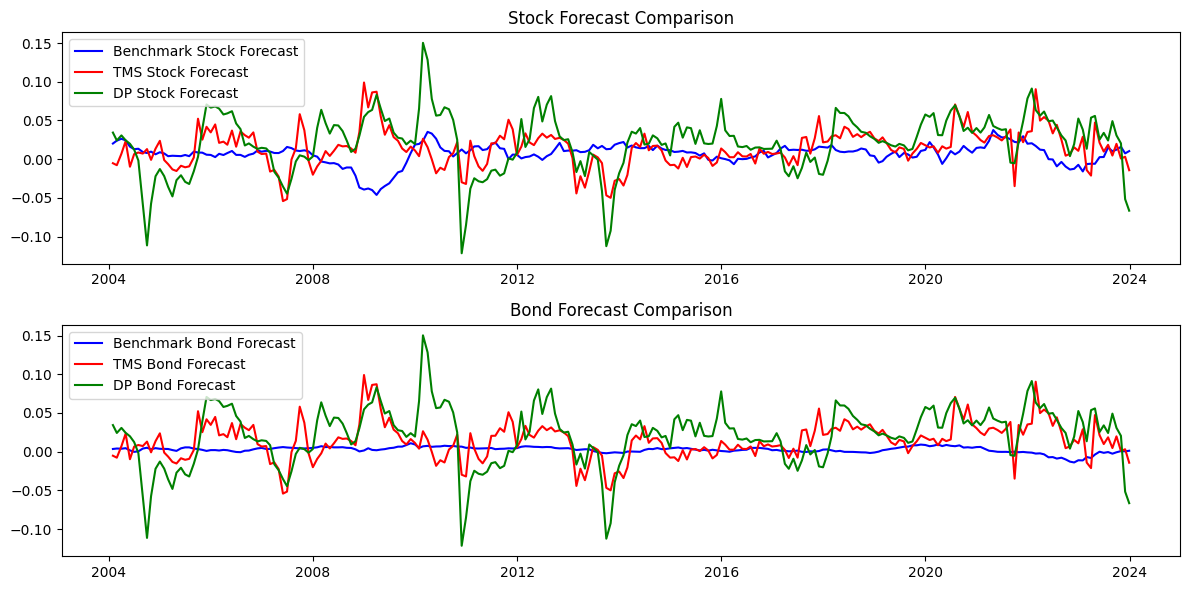

In [23]:
import matplotlib.pyplot as plt

# Adjust Date series to match the forecast length
aligned_dates = data_os['Date'][-len(stock_forecast_tms):]  # Trim the dates to match forecast length

# Plot the time series for the benchmark and the model forecasts for Stock and Bond
plt.figure(figsize=(12, 6))

# Plot for Stock
plt.subplot(2, 1, 1)
plt.plot(aligned_dates, benchmark['Stock_Benchmark_Forecast'][-len(stock_forecast_tms):], label="Benchmark Stock Forecast", color='blue')
plt.plot(aligned_dates, stock_forecast_tms, label="TMS Stock Forecast", color='red')
plt.plot(aligned_dates, stock_forecast_dp, label="DP Stock Forecast", color='green')
plt.title('Stock Forecast Comparison')
plt.legend(loc='best')

# Plot for Bond
plt.subplot(2, 1, 2)
plt.plot(aligned_dates, benchmark['Bond_Benchmark_Forecast'][-len(bond_forecast_tms):], label="Benchmark Bond Forecast", color='blue')
plt.plot(aligned_dates, bond_forecast_tms, label="TMS Bond Forecast", color='red')
plt.plot(aligned_dates, bond_forecast_dp, label="DP Bond Forecast", color='green')
plt.title('Bond Forecast Comparison')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


## Task 4
Generate the out-of-sample forecasts of the (2-by-2) sample variance-covariance matrix for a portfolio of the two asset classes using the same rolling window estimation approach.


In [24]:
import pandas as pd
import numpy as np

# Sample Data (replace with your actual returns data)
# Assume `data_os` has 'Stock_Excess_Returns' and 'Bond_Excess_Returns' columns
stock_returns = data_os['Stock_Excess_Returns']
bond_returns = data_os['Bond_Excess_Returns']

# Parameters
window_size = 12  # Rolling window size (e.g., 12 months or 1 year1)
out_of_sample_size = len(data_os) - window_size  # Number of out-of-sample points

# Placeholder for the rolling variance-covariance matrices
rolling_cov_matrices = []

# Rolling window estimation of the variance-covariance matrix
for i in range(out_of_sample_size):
    # Define the window of data for each iteration
    window_stock = stock_returns[i:i+window_size]
    window_bond = bond_returns[i:i+window_size]
    
    # Combine the stock and bond returns into a DataFrame for covariance calculation
    window_data = pd.DataFrame({'Stock': window_stock, 'Bond': window_bond})
    
    # Calculate the sample variance-covariance matrix for the window
    cov_matrix = window_data.cov()  # Sample variance-covariance matrix
    rolling_cov_matrices.append(cov_matrix)

# Convert the list of covariance matrices into a DataFrame for better visualization
rolling_cov_matrices_df = pd.concat(rolling_cov_matrices, axis=1, keys=range(1, out_of_sample_size+1))

# Show the first few rolling variance-covariance matrices
print(rolling_cov_matrices_df.head())

# You can access a specific rolling window's covariance matrix like this:
specific_cov_matrix = rolling_cov_matrices[10]  # Covariance matrix of the 11th rolling window
print(specific_cov_matrix)


            1                   2                   3                  4    \
          Stock      Bond     Stock      Bond     Stock      Bond    Stock   
Stock  0.003284 -0.000250  0.003086 -0.000292  0.002497 -0.000277  0.00232   
Bond  -0.000250  0.000119 -0.000292  0.000111 -0.000277  0.000111 -0.00036   

                      5              ...       260                 261  \
           Bond     Stock      Bond  ...     Stock      Bond     Stock   
Stock -0.000360  0.001985 -0.000359  ...  0.003011  0.000912  0.002825   
Bond   0.000155 -0.000359  0.000164  ...  0.000912  0.000596  0.000795   

                      262                 263                 264            
           Bond     Stock      Bond     Stock      Bond     Stock      Bond  
Stock  0.000795  0.002134  0.000518  0.001815  0.000652  0.002217  0.000830  
Bond   0.000534  0.000518  0.000423  0.000652  0.000431  0.000830  0.000493  

[2 rows x 528 columns]
          Stock      Bond
Stock  0.003692 -0.000564
Bo

Forecast for the first out-of-sample date:
                      Stock_Excess_Returns  Bond_Excess_Returns
Stock_Excess_Returns              0.003284            -0.000250
Bond_Excess_Returns              -0.000250             0.000119


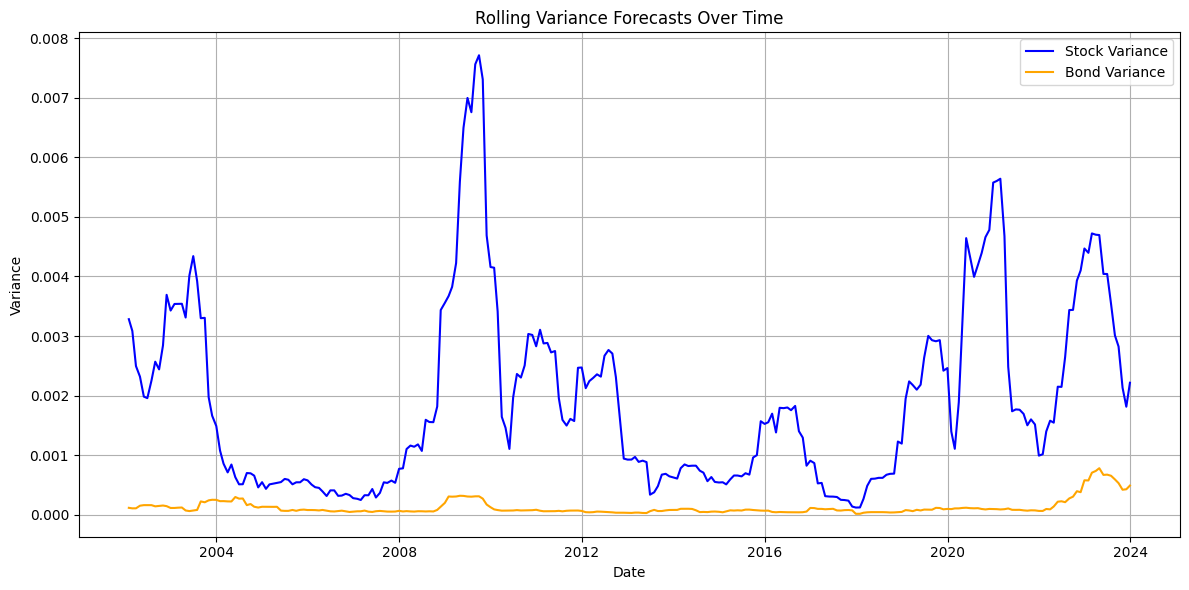

In [25]:
def rolling_variance_covariance_forecast(data, window_size):
    """
    Generate rolling window out-of-sample variance-covariance matrix forecasts.
    
    Parameters:
        data: DataFrame with 'Stock_Excess_Returns' and 'Bond_Excess_Returns'.
        window_size: Number of observations in the rolling window.
    
    Returns:
        A list of variance-covariance matrices as forecasts.
    """
    rolling_cov_matrices = []
    dates = []
    
    for i in range(window_size, len(data)):
        # Rolling window data
        window_data = data.iloc[i - window_size:i][['Stock_Excess_Returns', 'Bond_Excess_Returns']]
        
        # Compute the sample variance-covariance matrix
        cov_matrix = window_data.cov()
        
        # Append to results
        rolling_cov_matrices.append(cov_matrix)
        dates.append(data.iloc[i]['Date'])
    
    return rolling_cov_matrices, dates

# Generate the rolling variance-covariance matrices
cov_matrices, forecast_dates = rolling_variance_covariance_forecast(data_os, window_size=12)

# Convert the results into a DataFrame for better visualization
cov_matrices_df = pd.DataFrame({
    "Date": forecast_dates,
    "Covariance_Matrices": cov_matrices
})

# Example: Access the forecast for the 1st out-of-sample date
print("Forecast for the first out-of-sample date:")
print(cov_matrices[0])

# Example Plot: Variance of Stocks and Bonds over time
stock_variance = [mat.loc['Stock_Excess_Returns', 'Stock_Excess_Returns'] for mat in cov_matrices]
bond_variance = [mat.loc['Bond_Excess_Returns', 'Bond_Excess_Returns'] for mat in cov_matrices]

plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, stock_variance, label="Stock Variance", color="blue")
plt.plot(forecast_dates, bond_variance, label="Bond Variance", color="orange")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("Rolling Variance Forecasts Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Task 5
Using the benchmark excess return forecasts on the two assets and the sample variance-covariance matrix forecasts, construct out-of-sample optimal portfolio weights for a mean-variance investor. Compute the annualized summary statistics (mean, volatility, and Sharpe ratio) for the optimal portfolio’s excess return. The estimate of the weights of the optimal portfolio at time $t$ is:

$$
\hat{w}_t = \frac{1}{\lambda} \hat{\Sigma}_t^{-1} \hat{\mu}_t
$$

where $\hat{\mu}_t$ is a 2 × 1 vector of benchmark excess return forecasts on the two assets at time $t$, $\hat{\Sigma}$ is a 2 × 2 matrix, and $\lambda$ is the investor’s risk aversion parameter, which you should set to a value of 3.  

The out-of-sample portfolio excess return at time $t$ is given by:

$$
R_{p,t+1} = \hat{w}_t' r_{t+1}
$$

where $\hat{w}_t$ is the 2 × 1 vector of optimal portfolio weights at time $t$ calculated from equation (2), $r_{t+1}$ is a 2 × 1 vector of actual (realized) excess return on the two assets at time $t + 1$, and $'$ is the transpose operator.

Repeat the exercise with the 6 model forecasts in place of the benchmark excess return forecasts and compute the annualized summary statistics for portfolios generated.

Report the summary statistics in a table and explain the results. Does any statistical evidence of out-of-sample forecasting performance translate into economic gains/significance? In addition, create a figure showing the time-series of portfolio weights and cumulative excess returns for the optimal portfolio based on the benchmark forecast and the combination forecast.


In [26]:
import numpy as np
import pandas as pd

# Risk aversion parameter
lambda_ = 3

# Example data: replace with actual data
benchmark_forecasts = pd.DataFrame({
    "Stock": benchmark["Stock_Benchmark_Forecast"],  # Replace with actual stock excess return forecasts
    "Bond": benchmark["Bond_Benchmark_Forecast"]   # Replace with actual bond excess return forecasts
})
variance_covariance_forecasts = rolling_cov_matrices_df  # Replace with actual covariance matrices
realized_excess_returns = pd.DataFrame({
    "Stock": data_os["Stock_Excess_Returns"],  # Replace with actual stock realized returns
    "Bond": data_os["Bond_Excess_Returns"]   # Replace with actual bond realized returns
})

# Functions to compute weights and portfolio returns
def compute_portfolio_weights(mu, sigma, lambda_):
    """
    Compute optimal portfolio weights.
    """
    try:
        sigma_inv = np.linalg.inv(sigma)
    except np.linalg.LinAlgError:
        sigma += np.eye(sigma.shape[0]) * 1e-6
        sigma_inv = np.linalg.inv(sigma)
    return (1 / lambda_) * sigma_inv @ mu

def compute_portfolio_excess_returns(weights, realized_returns):
    """
    Compute portfolio excess returns.
    """
    return weights.T @ realized_returns

# Compute portfolio weights and returns
portfolio_weights = []
portfolio_excess_returns = []

for t in range(len(benchmark_forecasts)):
    # 2x1 vector of forecasts
    mu_t = benchmark_forecasts.iloc[t].values.reshape(-1, 1)
    
    # 2x2 covariance matrix
    sigma_t = rolling_cov_matrices[t]
    
    # Portfolio weights
    weights_t = compute_portfolio_weights(mu_t, sigma_t, lambda_)
    
    # 2x1 vector of realized returns
    realized_returns_t = realized_excess_returns.iloc[t].values.reshape(-1, 1)
    
    # Portfolio return
    portfolio_return_t = compute_portfolio_excess_returns(weights_t, realized_returns_t)
    
    portfolio_weights.append(weights_t)
    portfolio_excess_returns.append(portfolio_return_t)

portfolio_excess_returns = np.array(portfolio_excess_returns).flatten()

# Annualized summary statistics
def annualized_summary_statistics(portfolio_returns):
    mean_return = np.mean(portfolio_returns) * 12
    volatility = np.std(portfolio_returns) * np.sqrt(12)
    sharpe_ratio = mean_return / volatility
    return {"Mean": mean_return, "Volatility": volatility, "Sharpe Ratio": sharpe_ratio}

# Compute and display results
summary_stats = annualized_summary_statistics(portfolio_excess_returns)
print("Annualized Portfolio Summary Statistics:")
print(summary_stats)


Annualized Portfolio Summary Statistics:
{'Mean': 2.2873494394568072, 'Volatility': 1.0502210458345533, 'Sharpe Ratio': 2.177969531775261}


In [27]:
def compute_portfolio_for_forecasts(stock_forecasts, bond_forecasts, rolling_cov_matrices, realized_excess_returns, lambda_):
    """
    Compute portfolio weights and excess returns for given stock and bond forecasts.
    
    Parameters:
        stock_forecasts: DataFrame of stock excess return forecasts (columns are different models).
        bond_forecasts: DataFrame of bond excess return forecasts (columns are different models).
        rolling_cov_matrices: List of rolling variance-covariance matrices.
        realized_excess_returns: DataFrame of realized excess returns for stocks and bonds.
        lambda_: Risk aversion parameter.
    
    Returns:
        results: Dictionary containing portfolio returns and summary statistics for each model.
    """
    results = {}
    
    for stock_model in stock_forecasts.columns:
        for bond_model in bond_forecasts.columns:
            model_name = f"{stock_model}_{bond_model}"
            
            portfolio_excess_returns = []
            for t in range(len(stock_forecasts)):
                # Combine stock and bond forecasts for the current model
                mu_t = np.array([
                    stock_forecasts[stock_model].iloc[t],
                    bond_forecasts[bond_model].iloc[t]
                ]).reshape(-1, 1)
                
                # Get the rolling covariance matrix
                sigma_t = rolling_cov_matrices[t]
                
                # Compute portfolio weights
                weights_t = compute_portfolio_weights(mu_t, sigma_t, lambda_)
                
                # Compute portfolio excess return
                realized_returns_t = realized_excess_returns.iloc[t].values.reshape(-1, 1)
                portfolio_return_t = compute_portfolio_excess_returns(weights_t, realized_returns_t)
                portfolio_excess_returns.append(portfolio_return_t)
            
            portfolio_excess_returns = np.array(portfolio_excess_returns).flatten()
            
            # Compute summary statistics
            summary_stats = annualized_summary_statistics(portfolio_excess_returns)
            
            # Store results
            results[model_name] = {
                "Portfolio Returns": portfolio_excess_returns,
                "Summary Statistics": summary_stats
            }
    
    return results


In [28]:
# Example: Replace with your actual forecast data
stock_forecasts = pd.DataFrame({
    "stock_forecast_tms": stock_forecast_tms,
    "stock_forecast_dp": stock_forecast_dp,
    "stock_forecast_dfy": stock_forecast_dfy,
    "stock_forecast_shtint": stock_forecast_shtint,
    "stock_forecast_infl": stock_forecast_infl,
    "combined_forecast_stock": combined_forecast_stock
})

bond_forecasts = pd.DataFrame({
    "bond_forecast_tms": bond_forecast_tms,
    "bond_forecast_dp": bond_forecast_dp,
    "bond_forecast_dfy": bond_forecast_dfy,
    "bond_forecast_shtint": bond_forecast_shtint,
    "bond_forecast_infl": bond_forecast_infl,
    "combined_forecast_bond": combined_forecast_bond
})


In [29]:
combined_forecast_bond

0      0.023585
1      0.011106
2      0.019441
3      0.027891
4      0.015685
         ...   
235    0.009161
236    0.016510
237    0.015123
238   -0.002702
239   -0.014610
Name: retx_forecast, Length: 240, dtype: float64

In [30]:
#print(stock_forecasts)
#print(rolling_cov_matrices)
print(realized_excess_returns)

        Stock      Bond
0    0.034583  0.016300
1   -0.092329  0.008673
2   -0.064247  0.004978
3    0.076775 -0.004189
4    0.005058  0.006000
..        ...       ...
271 -0.017761 -0.006432
272 -0.048762 -0.025457
273 -0.022027 -0.015827
274  0.089135  0.045240
275  0.044186  0.038237

[276 rows x 2 columns]


In [31]:
print("Length of stock_forecasts:", len(stock_forecasts))
print("Length of bond_forecasts:", len(bond_forecasts))
print("Length of rolling_cov_matrices:", len(rolling_cov_matrices))
print("Length of realized_excess_returns:", len(realized_excess_returns))

Length of stock_forecasts: 240
Length of bond_forecasts: 240
Length of rolling_cov_matrices: 264
Length of realized_excess_returns: 276


In [32]:
# Determine the minimum length across all datasets
min_length = min(len(stock_forecasts), len(bond_forecasts), len(rolling_cov_matrices), len(realized_excess_returns))

# Truncate all datasets to the minimum length
stock_forecasts = stock_forecasts.iloc[:min_length].reset_index(drop=True)
bond_forecasts = bond_forecasts.iloc[:min_length].reset_index(drop=True)
rolling_cov_matrices = rolling_cov_matrices[:min_length]
realized_excess_returns = realized_excess_returns.iloc[:min_length].reset_index(drop=True)

# Check if the lengths are now consistent
print("Aligned Lengths:")
print("Stock Forecasts:", len(stock_forecasts))
print("Bond Forecasts:", len(bond_forecasts))
print("Rolling Covariance Matrices:", len(rolling_cov_matrices))
print("Realized Excess Returns:", len(realized_excess_returns))


Aligned Lengths:
Stock Forecasts: 240
Bond Forecasts: 240
Rolling Covariance Matrices: 240
Realized Excess Returns: 240


In [33]:
# Check for NaN values in rolling covariance matrices
# Ensure rolling_cov_matrices is a list of numpy arrays or pandas DataFrames
nan_in_cov_matrices = any([np.isnan(mat).any() if isinstance(mat, np.ndarray) else mat.isna().any().any() for mat in rolling_cov_matrices])

# Print results after cleaning the NaN values
print("NaN Check (After Dropping NaNs):")
print("Stock Forecasts NaN:", stock_forecasts.isna().sum())
print("Bond Forecasts NaN:", bond_forecasts.isna().sum())
print("Rolling Covariance Matrices NaN:", nan_in_cov_matrices)
print("Realized Excess Returns NaN:", realized_excess_returns.isna().sum())

# Re-run your calculations after cleaning the data
msfe_b_stock = calculate_msfe(data_os['Stock_Excess_Returns'], stock_forecasts['stock_forecast_tms'])
msfe_b_bond = calculate_msfe(data_os['Bond_Excess_Returns'], bond_forecasts['bond_forecast_tms'])

# Output the MSFE results
print(f"MSFE for Stock Forecasts: {msfe_b_stock}")
print(f"MSFE for Bond Forecasts: {msfe_b_bond}")



NaN Check (After Dropping NaNs):
Stock Forecasts NaN: stock_forecast_tms         0
stock_forecast_dp          0
stock_forecast_dfy         0
stock_forecast_shtint      0
stock_forecast_infl        0
combined_forecast_stock    0
dtype: int64
Bond Forecasts NaN: bond_forecast_tms         0
bond_forecast_dp          0
bond_forecast_dfy         0
bond_forecast_shtint      0
bond_forecast_infl        0
combined_forecast_bond    0
dtype: int64
Rolling Covariance Matrices NaN: False
Realized Excess Returns NaN: Stock    0
Bond     0
dtype: int64
MSFE for Stock Forecasts: 0.002525931293993648
MSFE for Bond Forecasts: 0.0007469109592202116


In [34]:
# Reindex the DataFrames/Series to ensure alignment
stock_forecasts = stock_forecasts.reset_index(drop=True)
bond_forecasts = bond_forecasts.reset_index(drop=True)
rolling_cov_matrices = [mat.reset_index(drop=True) if isinstance(mat, pd.DataFrame) else mat for mat in rolling_cov_matrices]
realized_excess_returns = realized_excess_returns.reset_index(drop=True)

# Check for NaN values in rolling covariance matrices
nan_in_cov_matrices = any([np.isnan(mat).any() if isinstance(mat, np.ndarray) else mat.isna().any().any() for mat in rolling_cov_matrices])

# Print results after cleaning the NaN values
print("NaN Check (After Dropping NaNs):")
print("Stock Forecasts NaN:", stock_forecasts.isna().sum())
print("Bond Forecasts NaN:", bond_forecasts.isna().sum())
print("Rolling Covariance Matrices NaN:", nan_in_cov_matrices)
print("Realized Excess Returns NaN:", realized_excess_returns.isna().sum())

# Re-run your calculations after cleaning the data
msfe_b_stock = calculate_msfe(data_os['Stock_Excess_Returns'], stock_forecasts['stock_forecast_tms'])
msfe_b_bond = calculate_msfe(data_os['Bond_Excess_Returns'], bond_forecasts['bond_forecast_tms'])

# Output the MSFE results
print(f"MSFE for Stock Forecasts: {msfe_b_stock}")
print(f"MSFE for Bond Forecasts: {msfe_b_bond}")


NaN Check (After Dropping NaNs):
Stock Forecasts NaN: stock_forecast_tms         0
stock_forecast_dp          0
stock_forecast_dfy         0
stock_forecast_shtint      0
stock_forecast_infl        0
combined_forecast_stock    0
dtype: int64
Bond Forecasts NaN: bond_forecast_tms         0
bond_forecast_dp          0
bond_forecast_dfy         0
bond_forecast_shtint      0
bond_forecast_infl        0
combined_forecast_bond    0
dtype: int64
Rolling Covariance Matrices NaN: False
Realized Excess Returns NaN: Stock    0
Bond     0
dtype: int64
MSFE for Stock Forecasts: 0.002525931293993648
MSFE for Bond Forecasts: 0.0007469109592202116


In [35]:
# Call the function to compute portfolio results for all model forecasts
portfolio_results = compute_portfolio_for_forecasts(
    stock_forecasts=stock_forecasts,
    bond_forecasts=bond_forecasts,
    rolling_cov_matrices=rolling_cov_matrices,
    realized_excess_returns=realized_excess_returns,
    lambda_=lambda_
)

# Display summary statistics for each model combination
for model_name, result in portfolio_results.items():
    print(f"Model: {model_name}")
    print("Summary Statistics:", result["Summary Statistics"])
    print()


Model: stock_forecast_tms_bond_forecast_tms
Summary Statistics: {'Mean': 4.000893747634659, 'Volatility': 4.283191751235536, 'Sharpe Ratio': 0.9340916727532813}

Model: stock_forecast_tms_bond_forecast_dp
Summary Statistics: {'Mean': 7.052061946358956, 'Volatility': 7.692829321241416, 'Sharpe Ratio': 0.9167058895856203}

Model: stock_forecast_tms_bond_forecast_dfy
Summary Statistics: {'Mean': 3.8253705503777624, 'Volatility': 4.2346186760071545, 'Sharpe Ratio': 0.9033565577112898}

Model: stock_forecast_tms_bond_forecast_shtint
Summary Statistics: {'Mean': 3.7475518503685388, 'Volatility': 3.5953715262135844, 'Sharpe Ratio': 1.0423267312002165}

Model: stock_forecast_tms_bond_forecast_infl
Summary Statistics: {'Mean': 4.029300716146028, 'Volatility': 3.9636684825424404, 'Sharpe Ratio': 1.0165584568670811}

Model: stock_forecast_tms_combined_forecast_bond
Summary Statistics: {'Mean': 4.531035762177189, 'Volatility': 3.8371655022913513, 'Sharpe Ratio': 1.1808288590813962}

Model: stock_f

In [44]:
# Compute portfolio weights and returns for all stock and bond forecasts
stock_portfolio_weights = {}
stock_portfolio_excess_returns = {}
bond_portfolio_weights = {}
bond_portfolio_excess_returns = {}

# Minimum length to avoid out-of-bounds errors
min_len = min(len(realized_excess_returns), len(rolling_cov_matrices))

# Loop over stock forecasts
for forecast_name in stock_forecasts.columns:
    stock_weights = []
    stock_excess_returns = []
    
    for t in range(min_len):
        # Forecast vector for stocks
        mu_t = np.array([stock_forecasts[forecast_name].iloc[t], 0]).reshape(-1, 1)  # Add bond return as zero
        
        # Covariance matrix
        sigma_t = rolling_cov_matrices[t]
        
        # Realized returns
        realized_returns_t = realized_excess_returns.iloc[t].values.reshape(-1, 1)
        
        # Portfolio weights
        weights_t = compute_portfolio_weights(mu_t, sigma_t, lambda_)
        stock_weights.append(weights_t)
        
        # Portfolio returns
        return_t = compute_portfolio_excess_returns(weights_t, realized_returns_t)
        stock_excess_returns.append(return_t)
    
    # Store results
    stock_portfolio_weights[forecast_name] = np.array(stock_weights)
    stock_portfolio_excess_returns[forecast_name] = np.array(stock_excess_returns).flatten()

# Loop over bond forecasts
for forecast_name in bond_forecasts.columns:
    bond_weights = []
    bond_excess_returns = []
    
    for t in range(min_len):
        # Forecast vector for bonds
        mu_t = np.array([0, bond_forecasts[forecast_name].iloc[t]]).reshape(-1, 1)  # Add stock return as zero
        
        # Covariance matrix
        sigma_t = rolling_cov_matrices[t]
        
        # Realized returns
        realized_returns_t = realized_excess_returns.iloc[t].values.reshape(-1, 1)
        
        # Portfolio weights
        weights_t = compute_portfolio_weights(mu_t, sigma_t, lambda_)
        bond_weights.append(weights_t)
        
        # Portfolio returns
        return_t = compute_portfolio_excess_returns(weights_t, realized_returns_t)
        bond_excess_returns.append(return_t)
    
    # Store results
    bond_portfolio_weights[forecast_name] = np.array(bond_weights)
    bond_portfolio_excess_returns[forecast_name] = np.array(bond_excess_returns).flatten()

# Display results


import pandas as pd

# Convert stock forecast portfolio returns to a DataFrame
stock_results = pd.DataFrame(stock_portfolio_excess_returns).apply(
    lambda col: annualized_summary_statistics(col)
).T

# Convert bond forecast portfolio returns to a DataFrame
bond_results = pd.DataFrame(bond_portfolio_excess_returns).apply(
    lambda col: annualized_summary_statistics(col)
).T

# Display results as tables
print("Stock Forecast Portfolio Returns:")
print(stock_results)
stock_results.to_excel("/Users/nilaysinghsolanki/Downloads/StockPredictor_Forecast_Summary_Stats.xlsx")

print("\nBond Forecast Portfolio Returns:")
print(bond_results)
bond_results.to_excel("/Users/nilaysinghsolanki/Downloads/BondPredictor_Forecast_Summary_Stats.xlsx")



Stock Forecast Portfolio Returns:
stock_forecast_tms         {'Mean': 1.0658623321684673, 'Volatility': 1.2...
stock_forecast_dp          {'Mean': 2.3033001221609815, 'Volatility': 2.3...
stock_forecast_dfy         {'Mean': 1.0253624486763273, 'Volatility': 1.1...
stock_forecast_shtint      {'Mean': 1.003208551542849, 'Volatility': 1.22...
stock_forecast_infl        {'Mean': 1.041729685525033, 'Volatility': 1.01...
combined_forecast_stock    {'Mean': 1.2878926280147316, 'Volatility': 1.2...
dtype: object

Bond Forecast Portfolio Returns:
bond_forecast_tms         {'Mean': 2.935031415466191, 'Volatility': 3.93...
bond_forecast_dp          {'Mean': 5.98619961419049, 'Volatility': 7.382...
bond_forecast_dfy         {'Mean': 2.7595082182092954, 'Volatility': 3.8...
bond_forecast_shtint      {'Mean': 2.6816895182000726, 'Volatility': 3.2...
bond_forecast_infl        {'Mean': 2.96343838397756, 'Volatility': 3.688...
combined_forecast_bond    {'Mean': 3.465173430008722, 'Volatility': 3.41...


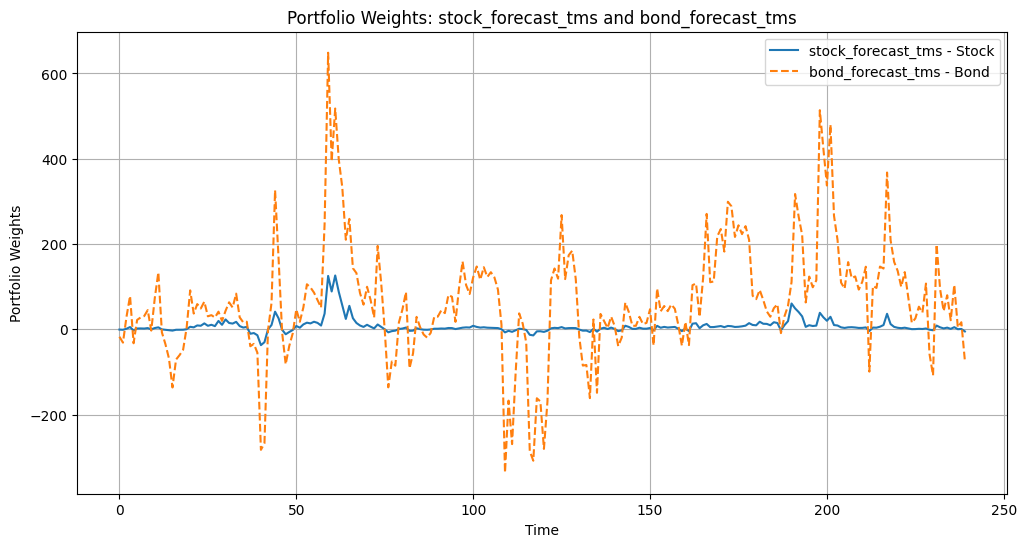

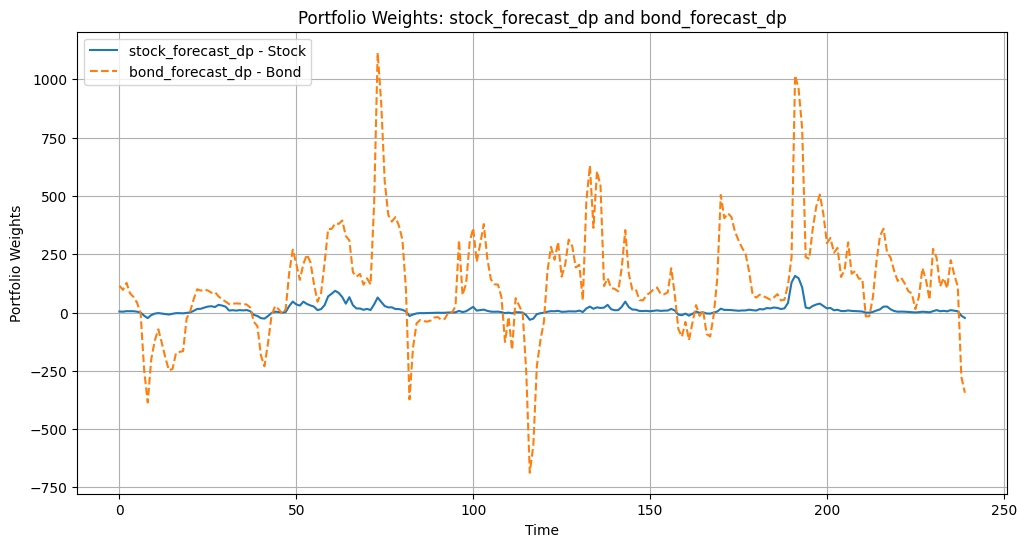

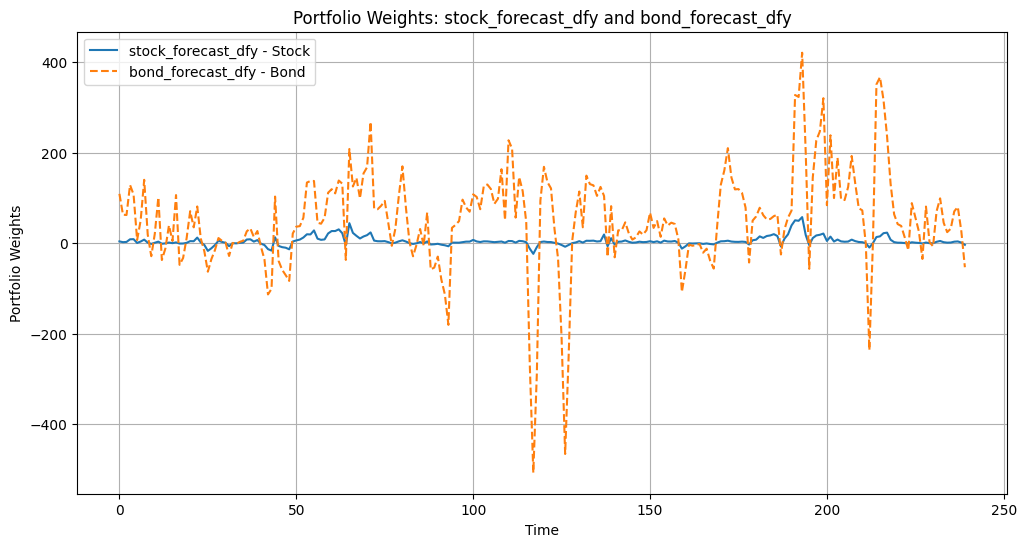

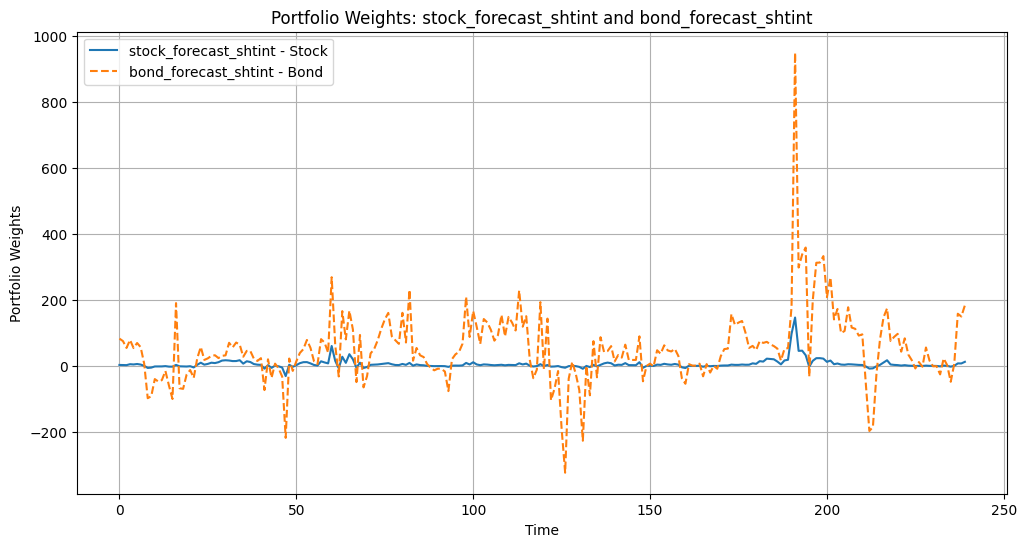

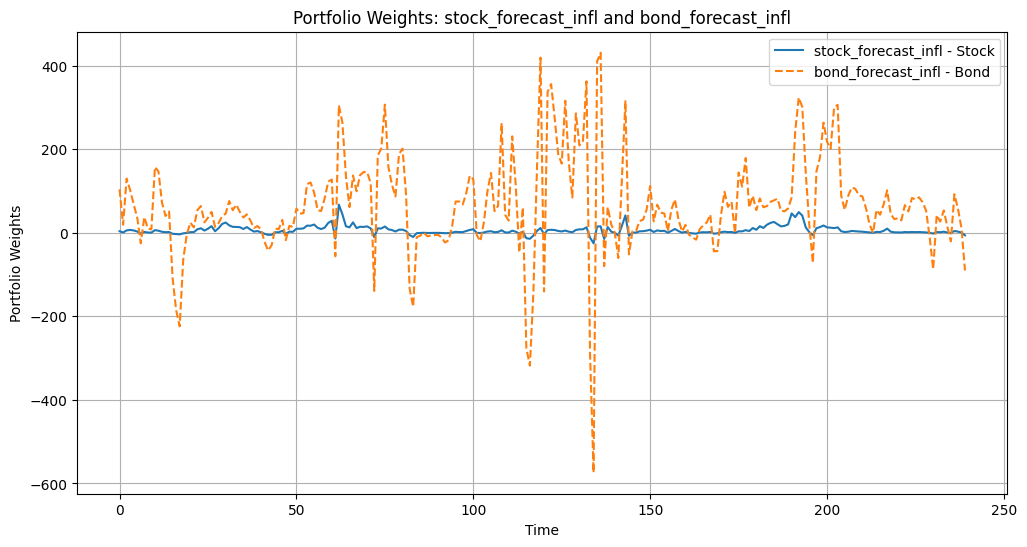

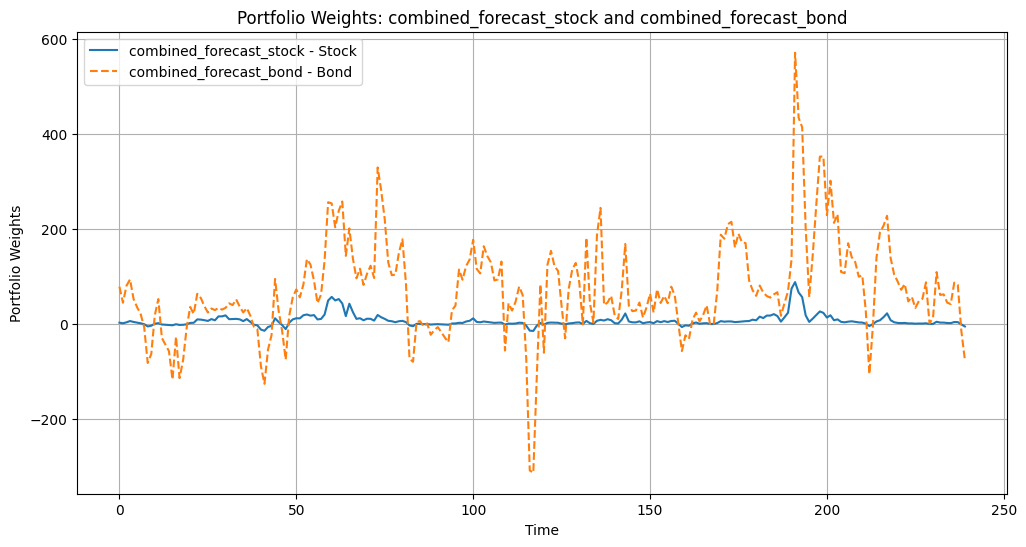

In [47]:
import matplotlib.pyplot as plt

# Function to plot portfolio weights for each stock and bond forecast pair
def plot_separate_portfolio_weights(stock_weights, bond_weights, forecast_pairs):
    """
    Plot time series of portfolio weights for each stock and bond forecast pair.
    
    Args:
        stock_weights: Dictionary of stock portfolio weights.
        bond_weights: Dictionary of bond portfolio weights.
        forecast_pairs: List of tuples with paired stock and bond forecast names.
    """
    for stock_forecast, bond_forecast in forecast_pairs:
        plt.figure(figsize=(12, 6))
        
        # Extract stock and bond weights
        stock_series = stock_weights[stock_forecast][:, 0]  # Stock weights
        bond_series = bond_weights[bond_forecast][:, 1]     # Bond weights
        
        # Plot the weights
        plt.plot(stock_series, label=f"{stock_forecast} - Stock", linestyle="-")
        plt.plot(bond_series, label=f"{bond_forecast} - Bond", linestyle="--")
        
        # Customize the plot
        plt.title(f"Portfolio Weights: {stock_forecast} and {bond_forecast}")
        plt.xlabel("Time")
        plt.ylabel("Portfolio Weights")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

# Define forecast pairs
forecast_pairs = [
    ("stock_forecast_tms", "bond_forecast_tms"),
    ("stock_forecast_dp", "bond_forecast_dp"),
    ("stock_forecast_dfy", "bond_forecast_dfy"),
    ("stock_forecast_shtint", "bond_forecast_shtint"),
    ("stock_forecast_infl", "bond_forecast_infl"),
    ("combined_forecast_stock", "combined_forecast_bond")
]

# Generate separate plots for each forecast pair
plot_separate_portfolio_weights(
    stock_portfolio_weights,
    bond_portfolio_weights,
    forecast_pairs
)


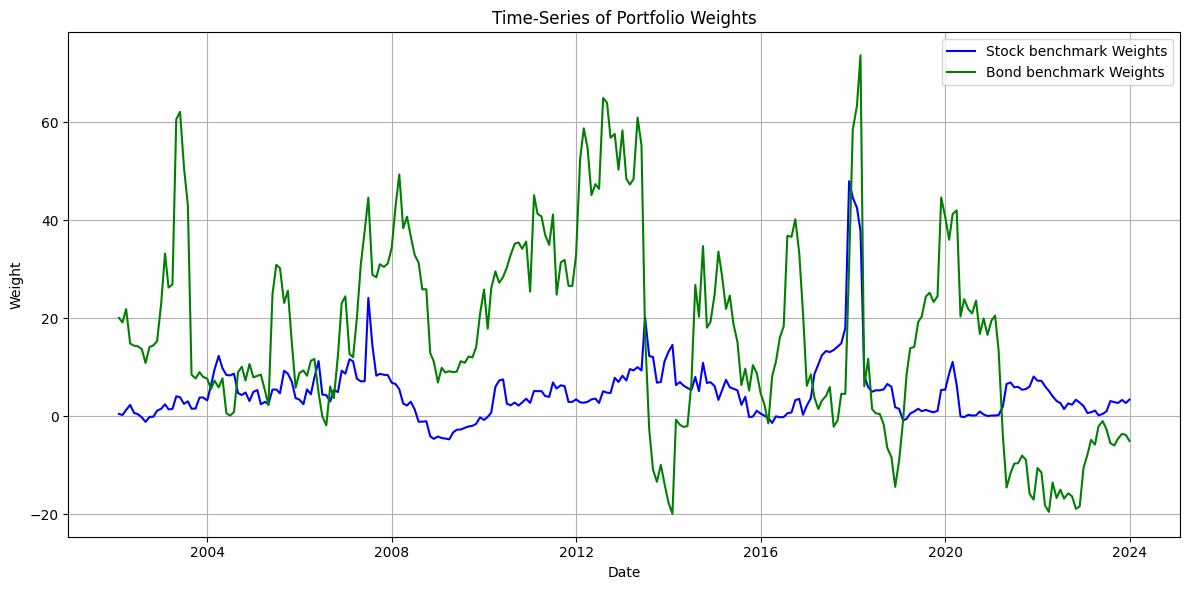

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with actual weights)
dates = data_os['Date'][-len(portfolio_weights):]  # Align dates with portfolio weights
weights_stock = np.array([w[0] for w in portfolio_weights])  # Extract stock weights
weights_bond = np.array([w[1] for w in portfolio_weights])   # Extract bond weights

# Plot time-series of portfolio weights
plt.figure(figsize=(12, 6))
plt.plot(dates, weights_stock, label="Stock benchmark Weights", color='blue')
plt.plot(dates, weights_bond, label="Bond benchmark Weights", color='green')
plt.title("Time-Series of Portfolio Weights")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()


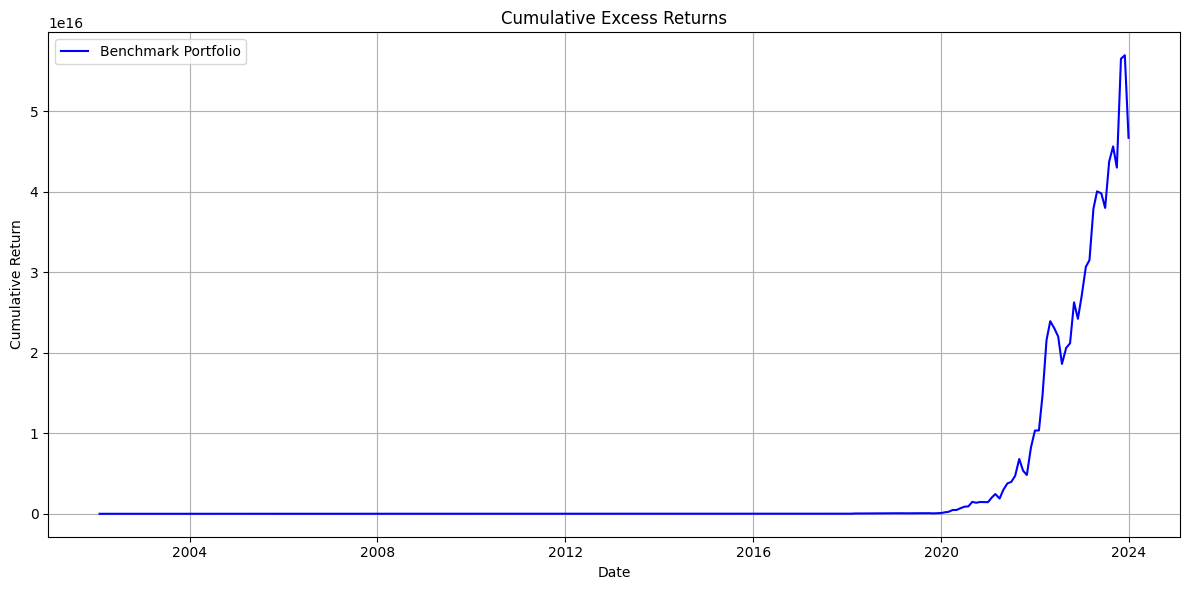

In [ ]:
# Compute cumulative excess returns
portfolio_cumulative_returns = np.cumprod(1 + portfolio_excess_returns) - 1

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_cumulative_returns, label="Benchmark Portfolio", color='blue')

model_portfolio_excess_returns = {}

# Replace these with actual model forecasts
model_forecasts = {
    "TMS Model": stock_forecast_tms,  # Example model forecast
    "DP Model": stock_forecast_dp,
    "DFY Model": stock_forecast_dfy,
    "SHTINI Model": stock_forecast_shtint,
    "INFL Model": stock_forecast_infl,                # Another example
    # Add other models as necessary
}

# Add model portfolios (example)
for model_name, model_returns in model_portfolio_excess_returns.items():
    model_cumulative_returns = np.cumprod(1 + model_returns) - 1
    plt.plot(dates, model_cumulative_returns, label=f"{model_name} Portfolio")

plt.title("Cumulative Excess Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()
